# ## 1. Setup and Imports
## 1.1 Import libraries

In [2]:

import glob
import os
import gc
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb
from ngboost import NGBClassifier
from ngboost.distns import Bernoulli
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

## 1.2 Set Global configuration

In [5]:
# -----------------------------
# Global configuration
# -----------------------------
DATA_PATH    = r"C:\Users\ss160\Desktop\My_Code\PycharmProjects\Ciciot23_practical\dataset\wataiData\csv\CICIoT2023"
LABEL_COL    = "label"
NEW_LABEL    = "binary_label"
BENIGN_NAME  = "BenignTraffic"
TARGET_ROWS  = 4_000_000
RANDOM_STATE = 42
CHUNK_SIZE   = 2_000_000
SUBSAMPLE_N  = 200_000

# Plot config
FIG_DPI   = 600
FIGSIZE   = (8, 5)
SAVE_DIR  = "figures"

sns.set_style("whitegrid")
np.random.seed(RANDOM_STATE)
os.makedirs(SAVE_DIR, exist_ok=True)

def _sanitize_name(s: str) -> str:
    return s.strip().lower().replace(" ", "_").replace("/", "_")

# ## 2) Original Binary Class Distribution

Counting labels: 100%|██████████| 169/169 [01:06<00:00,  2.55it/s]


Benign samples: 1,098,195
Attack samples: 45,588,384


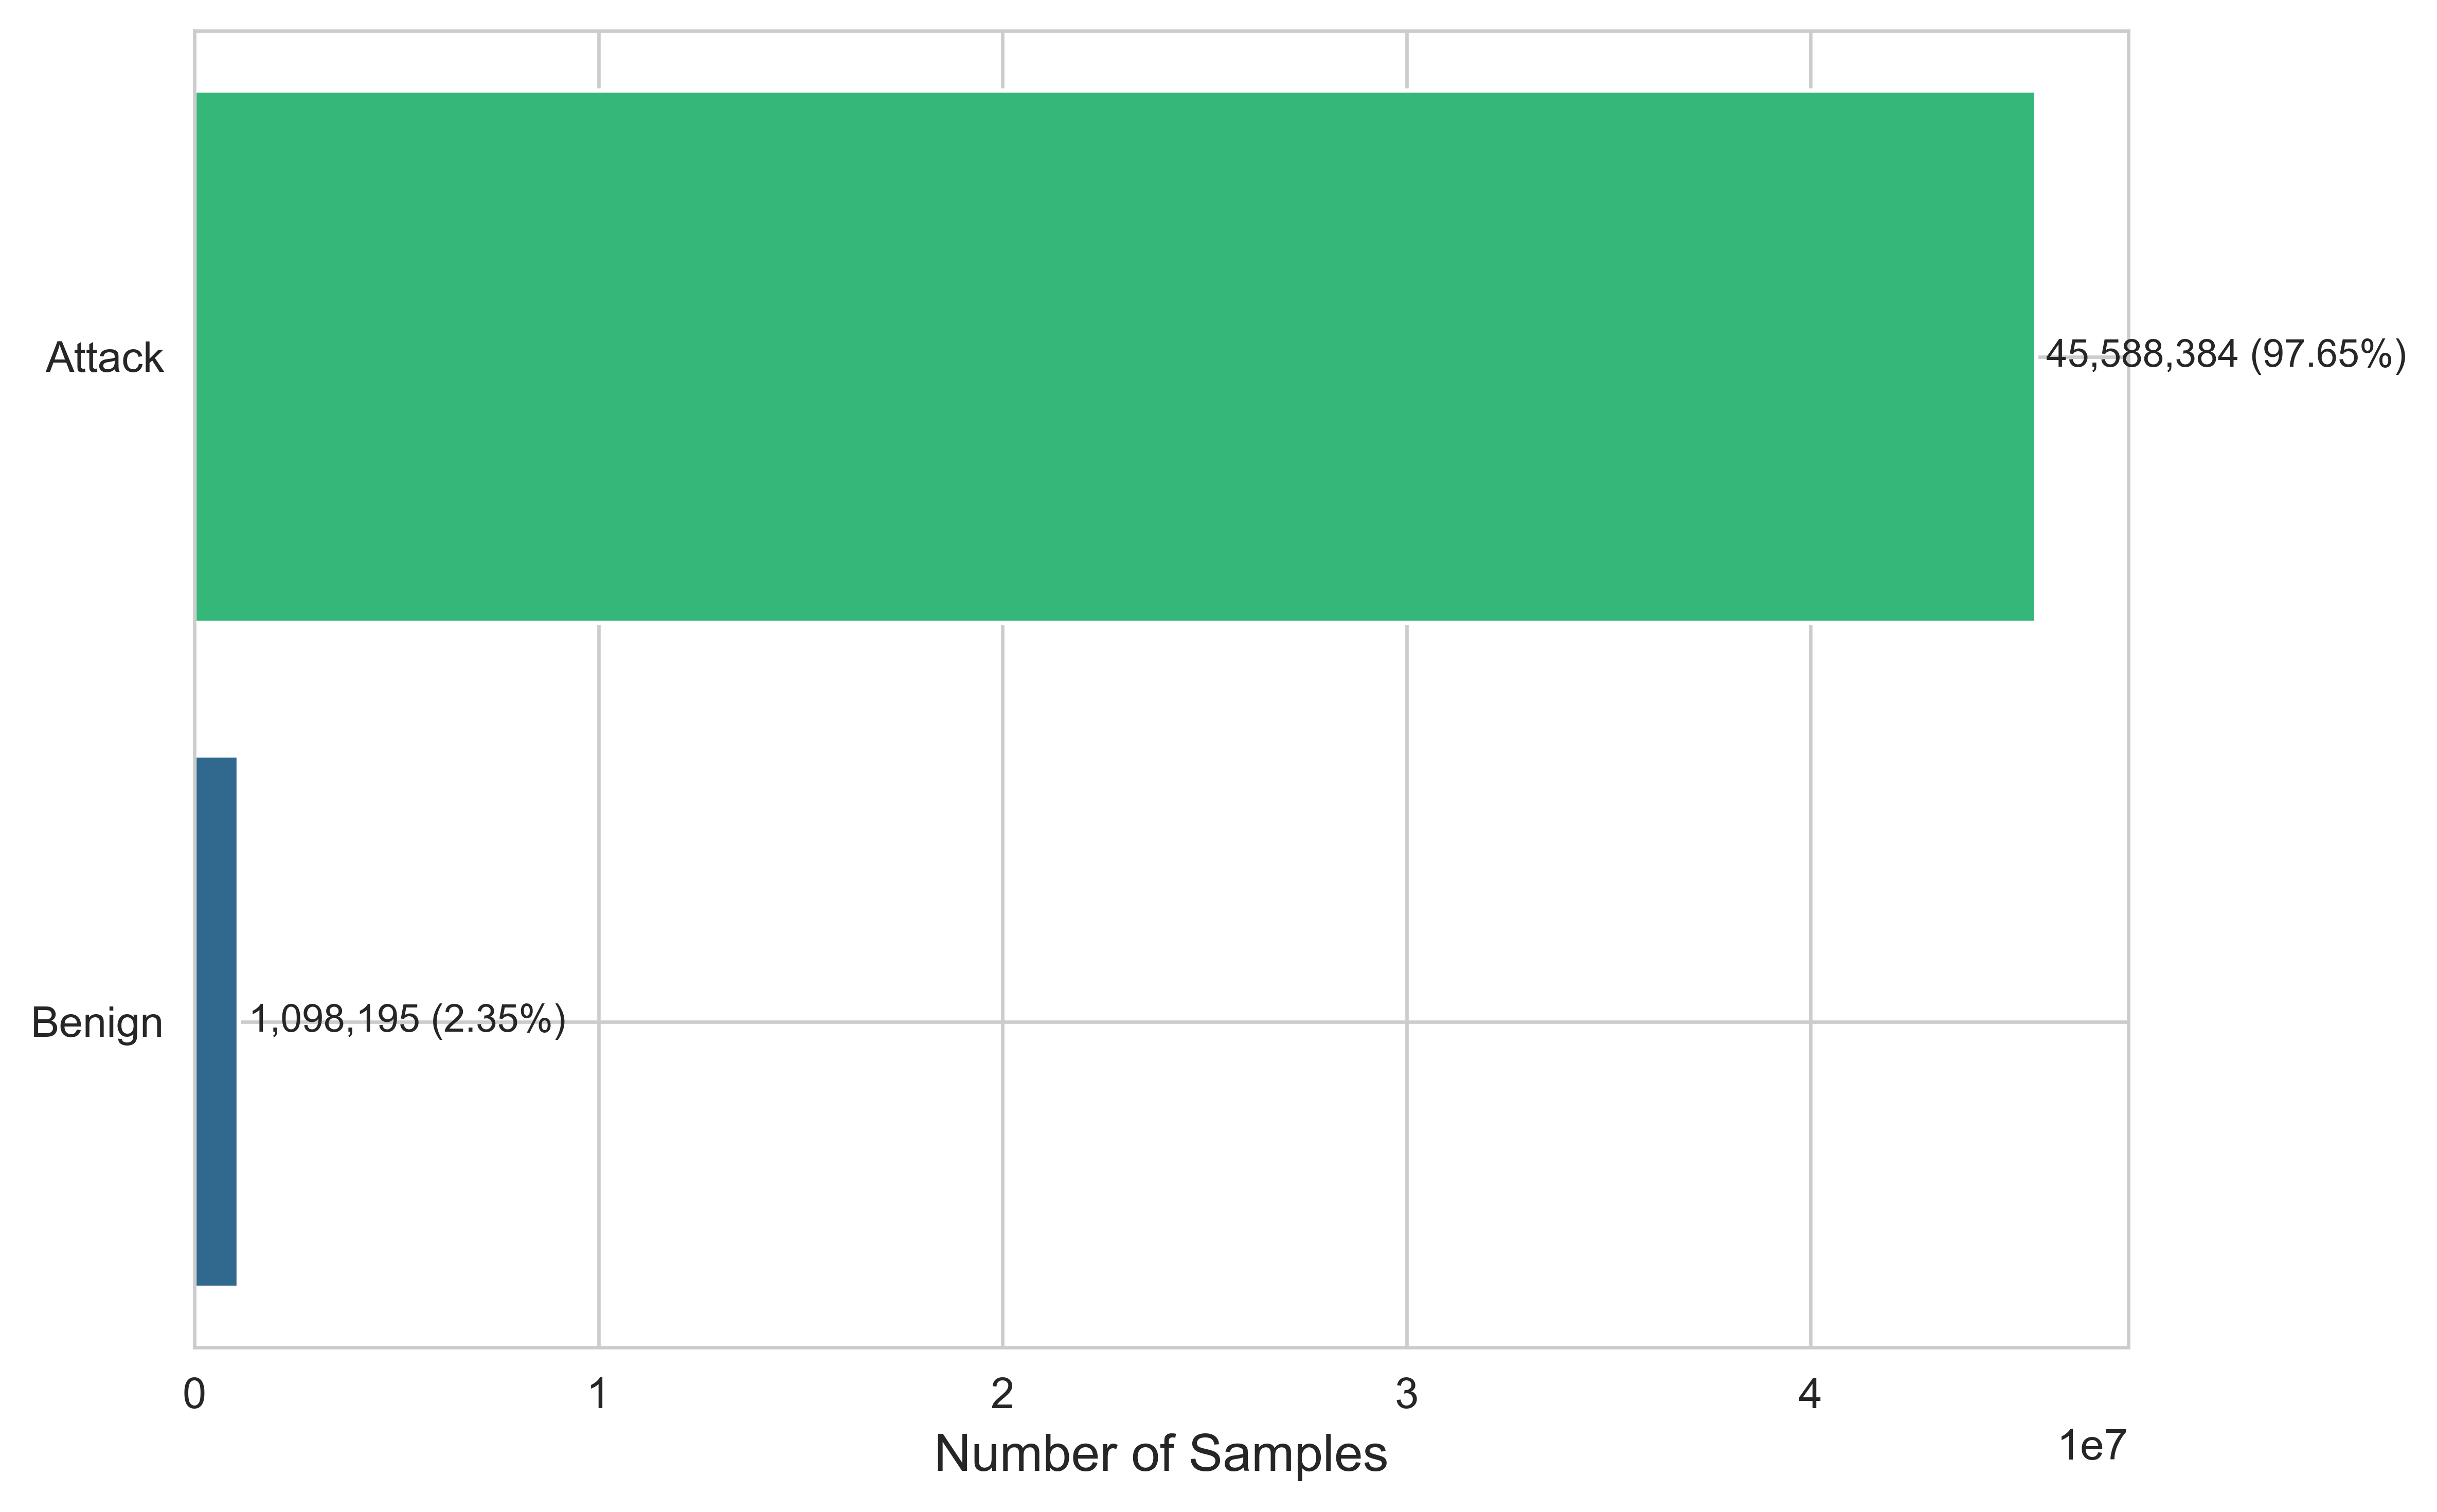

In [6]:

# 2.1 Gather dataset files
csv_files = sorted(glob.glob(os.path.join(DATA_PATH, "part-*.csv")))
assert csv_files, "No CSV files found in the specified path."

# 2.2 Count original label frequencies
label_counts = Counter()
for path in tqdm(csv_files, desc="Counting labels"):
    for chunk in pd.read_csv(path, usecols=[LABEL_COL], chunksize=CHUNK_SIZE):
        label_counts.update(chunk[LABEL_COL])

# 2.3 Benign vs Attack counts
benign_cnt = label_counts[BENIGN_NAME]
attack_cnt = sum(count for lbl, count in label_counts.items() if lbl != BENIGN_NAME)
total_rows = benign_cnt + attack_cnt

print(f"Benign samples: {benign_cnt:,}")
print(f"Attack samples: {attack_cnt:,}")


# 2.4 Plot and save binary distribution (بدون عنوان + حفظ JPEG)
def plot_binary_distribution(counts: dict, filename: str, palette: str = "viridis"):
    series = pd.Series(counts).sort_values()
    total = series.sum()

    fig, ax = plt.subplots(figsize=FIGSIZE, dpi=FIG_DPI)
    colors = sns.color_palette(palette, len(series))
    ax.barh(series.index, series.values, color=colors)

    for i, (label, value) in enumerate(series.items()):
        pct = (value / total) * 100
        ax.text(value + total * 0.005, i, f"{value:,} ({pct:.2f}%)", va="center", fontsize=9)

    # لا عنوان
    ax.set_xlabel("Number of Samples", fontsize=12)
    plt.tight_layout()
    out_path = os.path.join(SAVE_DIR, filename)
    plt.savefig(out_path, format="jpeg", dpi=FIG_DPI)
    plt.show()


plot_binary_distribution({"Benign": benign_cnt, "Attack": attack_cnt},
                         "binary_distribution.jpeg")

# ## 3) Stratified Undersampling for Binary Classes

In [7]:
keep_benign = benign_cnt
remaining_cap = max(0, TARGET_ROWS - keep_benign)
keep_attack = min(attack_cnt, remaining_cap)
print(f"Retaining benign samples: {keep_benign:,}")
print(f"Selecting attack samples: {keep_attack:,}")
print(f"Total undersampled size: {keep_benign + keep_attack:,}")


def map_to_binary(series):
    return np.where(series == BENIGN_NAME, "Benign", "Attack")


remaining = {"Benign": keep_benign, "Attack": keep_attack}
parts = []

for path in tqdm(csv_files, desc="Undersampling"):
    if all(v <= 0 for v in remaining.values()):
        break
    for chunk in pd.read_csv(path, chunksize=CHUNK_SIZE):
        if all(v <= 0 for v in remaining.values()):
            break
        chunk[NEW_LABEL] = map_to_binary(chunk[LABEL_COL])
        selected = []
        for cls in ("Benign", "Attack"):
            needed = remaining[cls]
            if needed <= 0:
                continue
            idx = chunk.index[chunk[NEW_LABEL] == cls].to_numpy()
            if idx.size == 0:
                continue
            take = min(needed, len(idx))
            choice = np.random.choice(idx, size=take, replace=False)
            selected.append(chunk.loc[choice])
            remaining[cls] -= take
        if selected:
            parts.append(pd.concat(selected, ignore_index=True))
gc.collect()

reduced_df = pd.concat(parts, ignore_index=True)
print(f"Undersampled dataset size: {len(reduced_df):,}")
print("Final class counts:\n", reduced_df[NEW_LABEL].value_counts())

Retaining benign samples: 1,098,195
Selecting attack samples: 2,901,805
Total undersampled size: 4,000,000


Undersampling: 100%|██████████| 169/169 [01:50<00:00,  1.52it/s]


Undersampled dataset size: 4,000,000
Final class counts:
 binary_label
Attack    2901805
Benign    1098195
Name: count, dtype: int64


# ## 4) Feature Selection via LightGBM Gain

In [9]:
fs_df = reduced_df.sample(n=min(len(reduced_df), SUBSAMPLE_N), random_state=RANDOM_STATE)
fs_df["y_num"] = (fs_df[NEW_LABEL] == "Attack").astype(int)

X_fs = fs_df.drop([LABEL_COL, NEW_LABEL, "y_num"], axis=1)
y_fs = fs_df["y_num"]
lgb_train = lgb.Dataset(X_fs, y_fs, free_raw_data=False)

fs_params = {
    "objective": "binary",
    "learning_rate": 0.1,
    "num_leaves": 31,
    "min_data_in_leaf": 100,
    "verbosity": -1,
    "seed": RANDOM_STATE,
}
fs_model = lgb.train(fs_params, lgb_train, num_boost_round=100,
                     valid_sets=[lgb_train],
                     callbacks=[ lgb.log_evaluation(50)])

importances = pd.Series(fs_model.feature_importance("gain"), index=X_fs.columns)
threshold = importances.median()
selected_feats = importances[importances > threshold].index.tolist()
print(f"Selected {len(selected_feats)} / {X_fs.shape[1]} features")


[50]	training's binary_logloss: 0.0171876
[100]	training's binary_logloss: 0.0109581
Selected 23 / 46 features


# ## 5) Train/Test Split and Scaling

In [10]:
X = reduced_df[selected_feats].values
y = (reduced_df[NEW_LABEL] == "Attack").astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"scale_pos_weight = {scale_pos_weight:.2f}")

scale_pos_weight = 0.38


# ## 6) Model Training and Evaluation

In [40]:


def save_classification_report_as_image(report_text: str, model_name: str):
    lines = report_text.strip().split("\n")
    max_line_len = max(len(line) for line in lines)

    # احسب الحجم المناسب بناءً على طول النص وعدد الأسطر
    fig_width = max_line_len * 0.15   # يعتمد على عدد الأحرف
    fig_height = len(lines) * 0.1    # يعتمد على عدد الأسطر

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=FIG_DPI)
    ax.axis('off')

    ax.text(0, 1, report_text, fontsize=14, va='top', ha='left', family='monospace')

    # استخدم bbox_inches='tight' و pad_inches صغير جدًا لإزالة الفراغات
    filename = f"classification_report_{_sanitize_name(model_name)}.jpeg"
    out_path = os.path.join(SAVE_DIR, filename)
    plt.savefig(out_path, format="jpeg", dpi=FIG_DPI, bbox_inches='tight', pad_inches=0.01)
    plt.close(fig)



def evaluate_model(model, name, cmap="Blues"):
    y_pred = model.predict(X_test)
    acc    = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=["Benign","Attack"], digits=4)

    print(f"{name} Accuracy: {acc*100:.2f}%")
    print(report)

    # حفظ التقرير كصورة
    save_classification_report_as_image(report, name)

    # رسم وحفظ مصفوفة الالتباس
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(6, 5), dpi=FIG_DPI)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap,
                xticklabels=["Benign","Attack"],
                yticklabels=["Benign","Attack"], ax=ax)
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")
    plt.tight_layout()
    fname = f"confusion_matrix_{_sanitize_name(name)}.jpeg"
    plt.savefig(os.path.join(SAVE_DIR, fname), format="jpeg", dpi=FIG_DPI)
    plt.show()


# 6.1 XGBoost

[0]	validation_0-logloss:0.58199
[50]	validation_0-logloss:0.01519
[100]	validation_0-logloss:0.01375
[150]	validation_0-logloss:0.01364
[200]	validation_0-logloss:0.01375
[250]	validation_0-logloss:0.01389
[300]	validation_0-logloss:0.01406
[350]	validation_0-logloss:0.01436
[399]	validation_0-logloss:0.01460


C:\Users\ss160\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:729: UserWarning: [18:29:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


XGBoost Accuracy: 99.61%
              precision    recall  f1-score   support

      Benign       0.99      1.00      0.99    219639
      Attack       1.00      1.00      1.00    580361

    accuracy                           1.00    800000
   macro avg       0.99      1.00      1.00    800000
weighted avg       1.00      1.00      1.00    800000



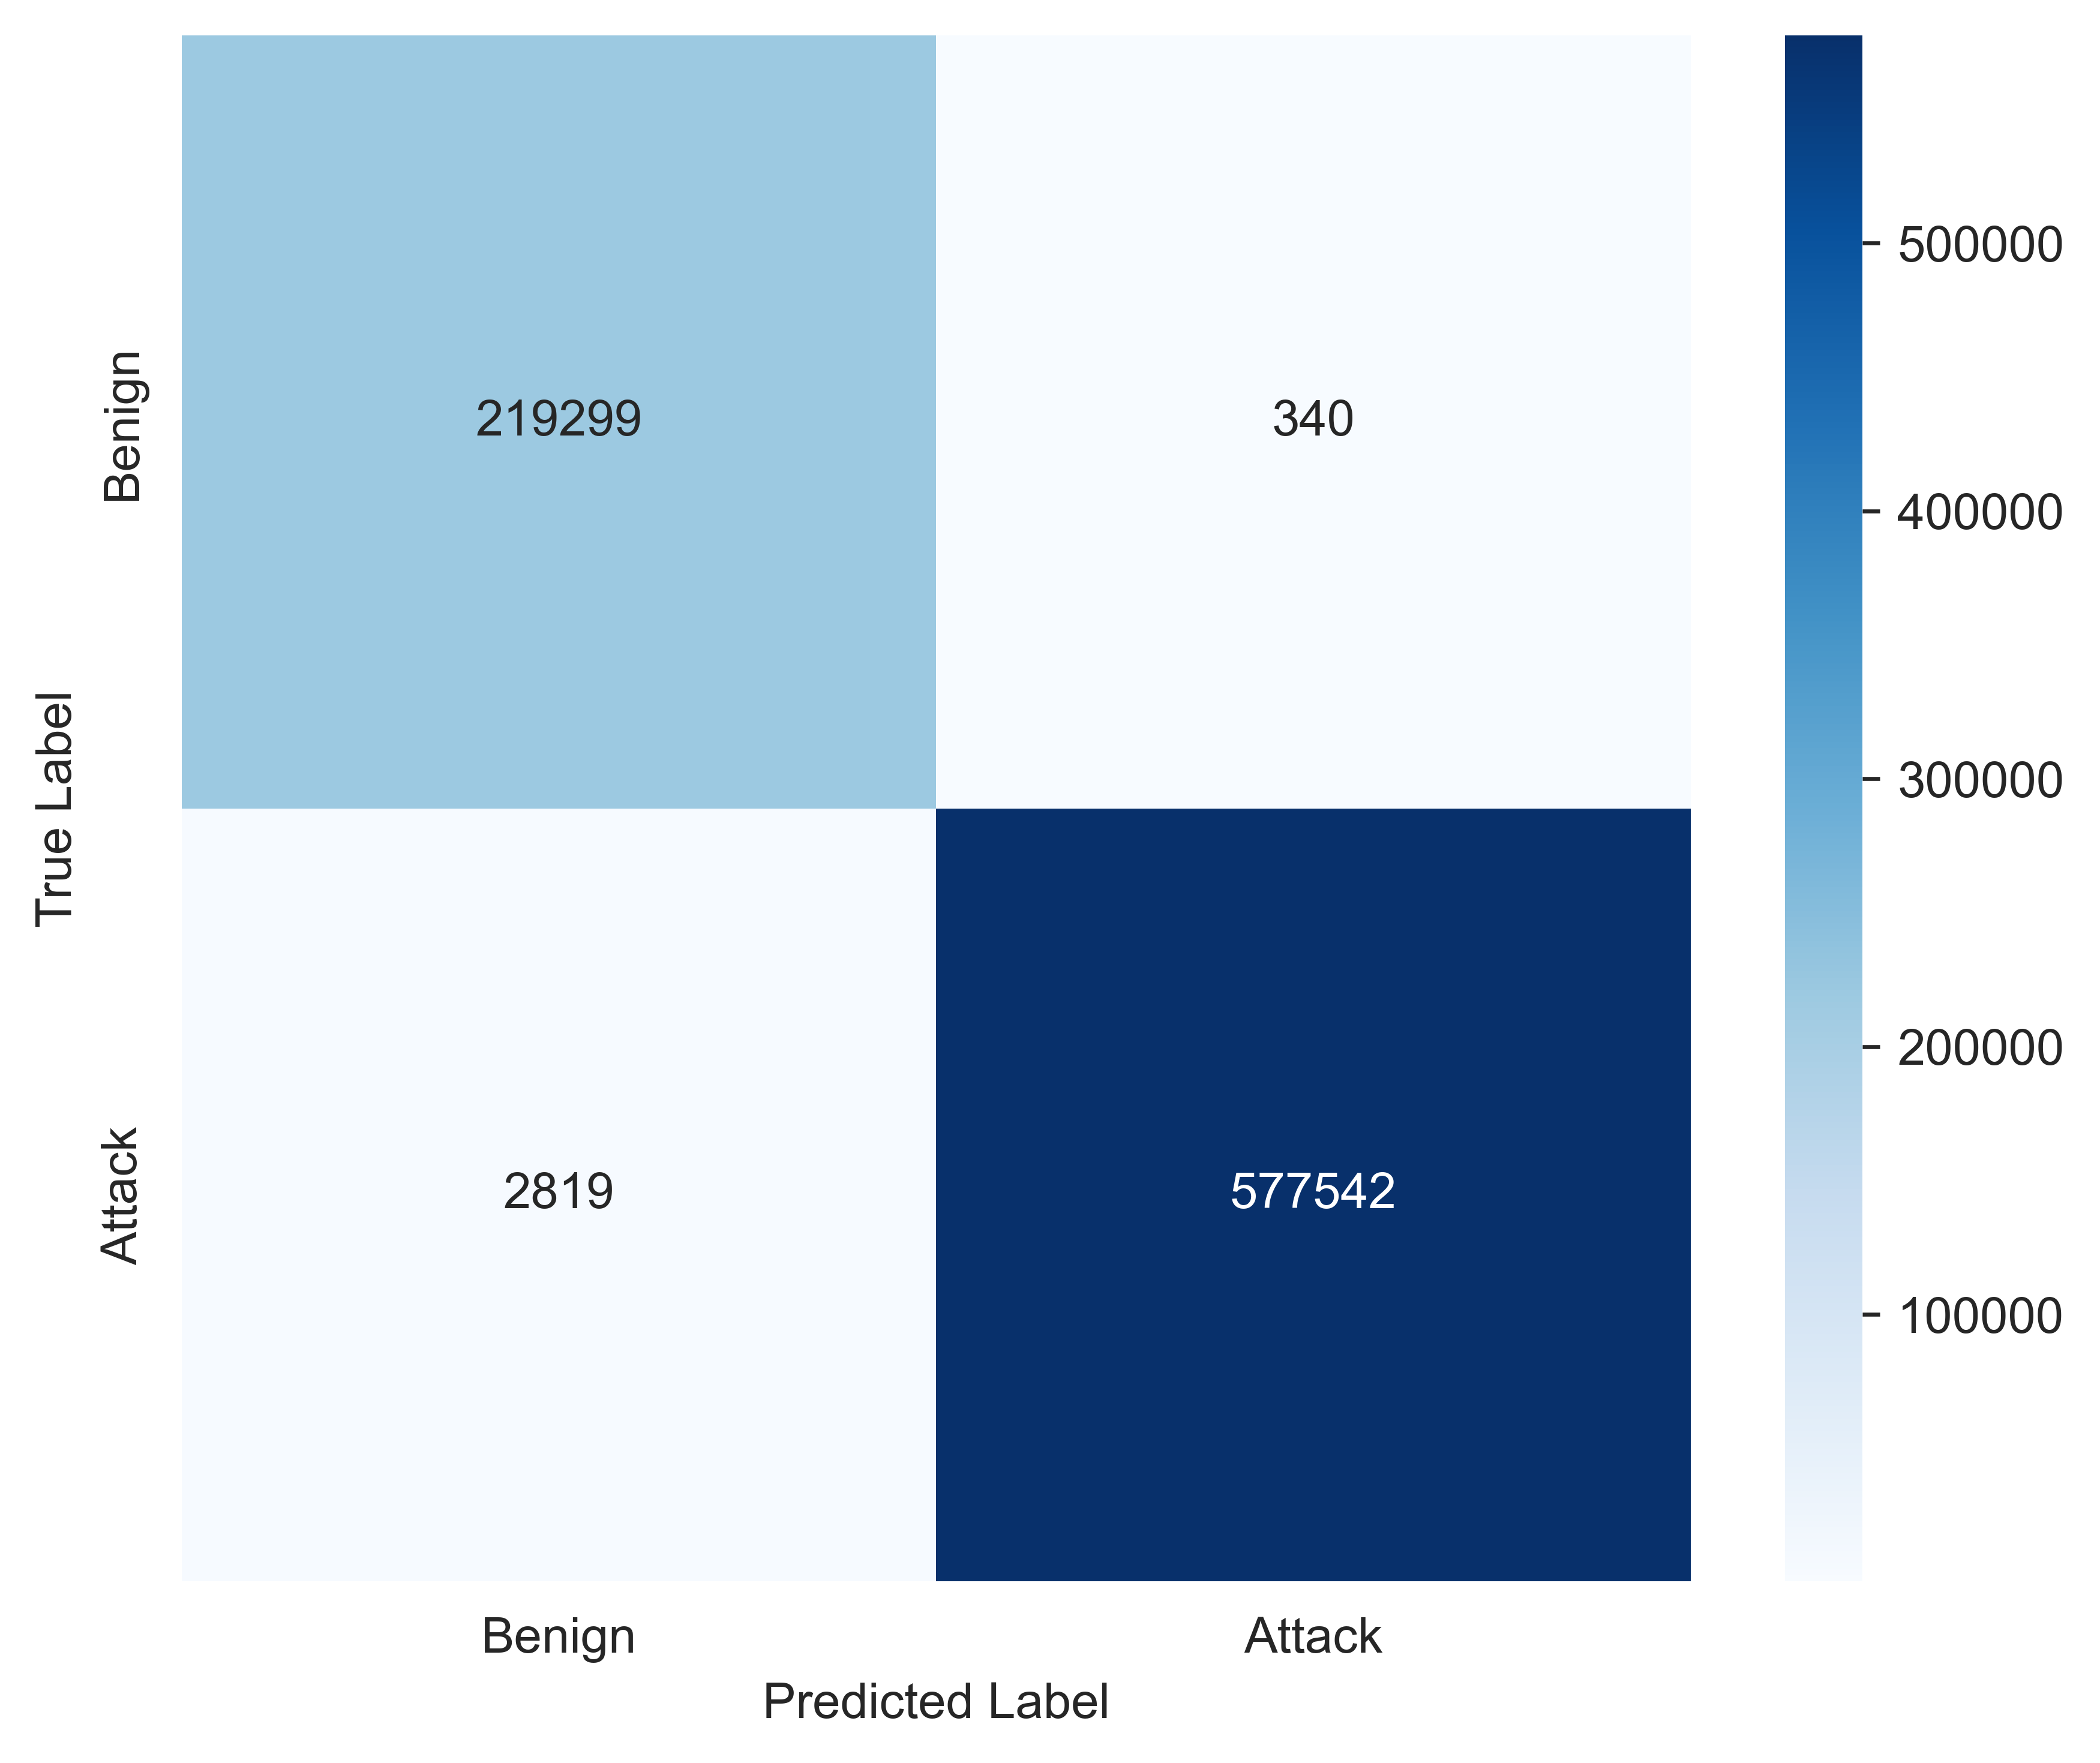

In [13]:
clf_xgb = xgb.XGBClassifier(
    objective        ="binary:logistic",
    eval_metric      ="logloss",
    n_estimators     =500,
    learning_rate    =0.12,
    max_depth        =14,
    subsample        =0.8,
    colsample_bytree =0.8,
    scale_pos_weight =scale_pos_weight,
    random_state     =RANDOM_STATE,
    tree_method      ="hist",
    device           ="cuda"
)
clf_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=50
)
evaluate_model(clf_xgb, "XGBoost", cmap="Blues")

# 6.2 LightGBM

C:\Users\ss160\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 99.51%
              precision    recall  f1-score   support

      Benign       0.98      1.00      0.99    219639
      Attack       1.00      0.99      1.00    580361

    accuracy                           1.00    800000
   macro avg       0.99      1.00      0.99    800000
weighted avg       1.00      1.00      1.00    800000



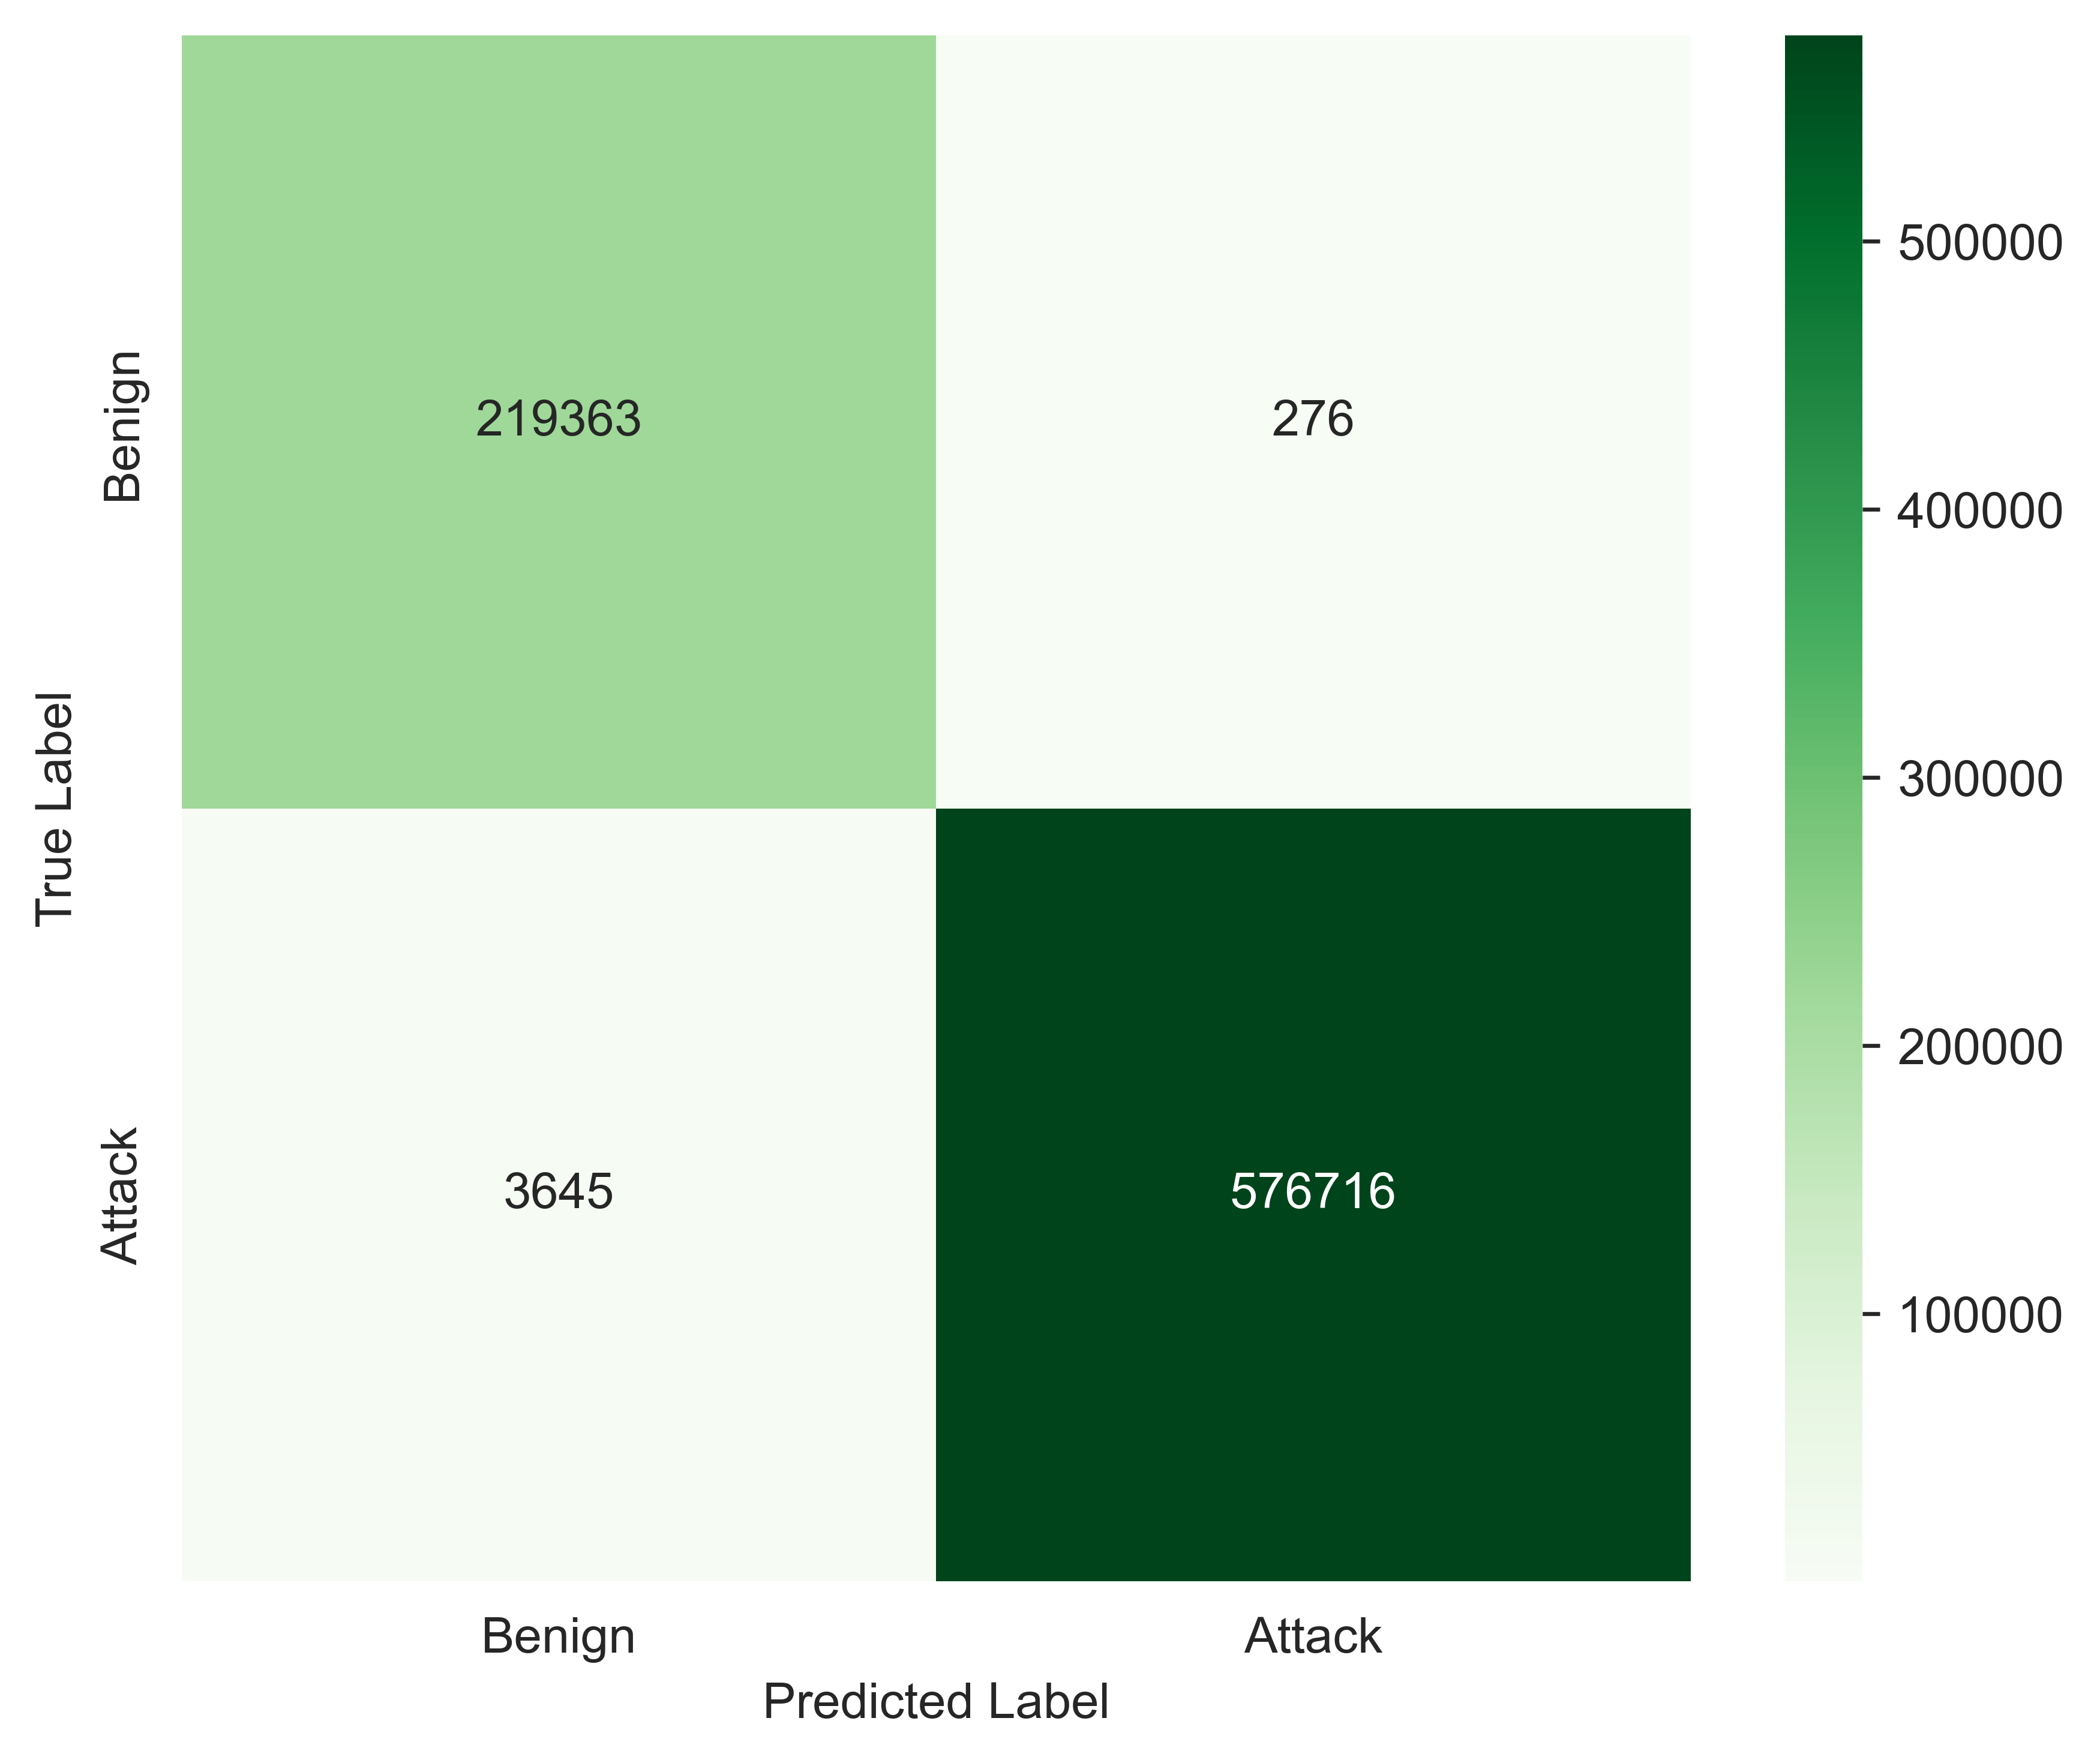

In [14]:
clf_lgb = lgb.LGBMClassifier(
    objective        ="binary",
    boosting_type    ="gbdt",
    n_estimators     =500,
    learning_rate    =0.12,
    max_depth        =14,
    subsample        =0.8,
    colsample_bytree =0.8,
    scale_pos_weight =scale_pos_weight,
    random_state     =RANDOM_STATE,
    device           ="gpu",
)
clf_lgb.fit(X_train, y_train)
evaluate_model(clf_lgb, "LightGBM", cmap="Greens")

# 6.3 CatBoost

0:	learn: 0.3236456	total: 212ms	remaining: 1m 45s
50:	learn: 0.0126216	total: 9.02s	remaining: 1m 19s
100:	learn: 0.0109130	total: 18s	remaining: 1m 10s
150:	learn: 0.0096734	total: 27s	remaining: 1m 2s
200:	learn: 0.0087918	total: 35.9s	remaining: 53.5s
250:	learn: 0.0080772	total: 44.9s	remaining: 44.5s
300:	learn: 0.0074780	total: 53.8s	remaining: 35.6s
350:	learn: 0.0069267	total: 1m 2s	remaining: 26.6s
400:	learn: 0.0064878	total: 1m 11s	remaining: 17.7s
450:	learn: 0.0061066	total: 1m 20s	remaining: 8.73s
499:	learn: 0.0057546	total: 1m 29s	remaining: 0us
CatBoost Accuracy: 99.57%
              precision    recall  f1-score   support

      Benign       0.99      1.00      0.99    219639
      Attack       1.00      0.99      1.00    580361

    accuracy                           1.00    800000
   macro avg       0.99      1.00      0.99    800000
weighted avg       1.00      1.00      1.00    800000



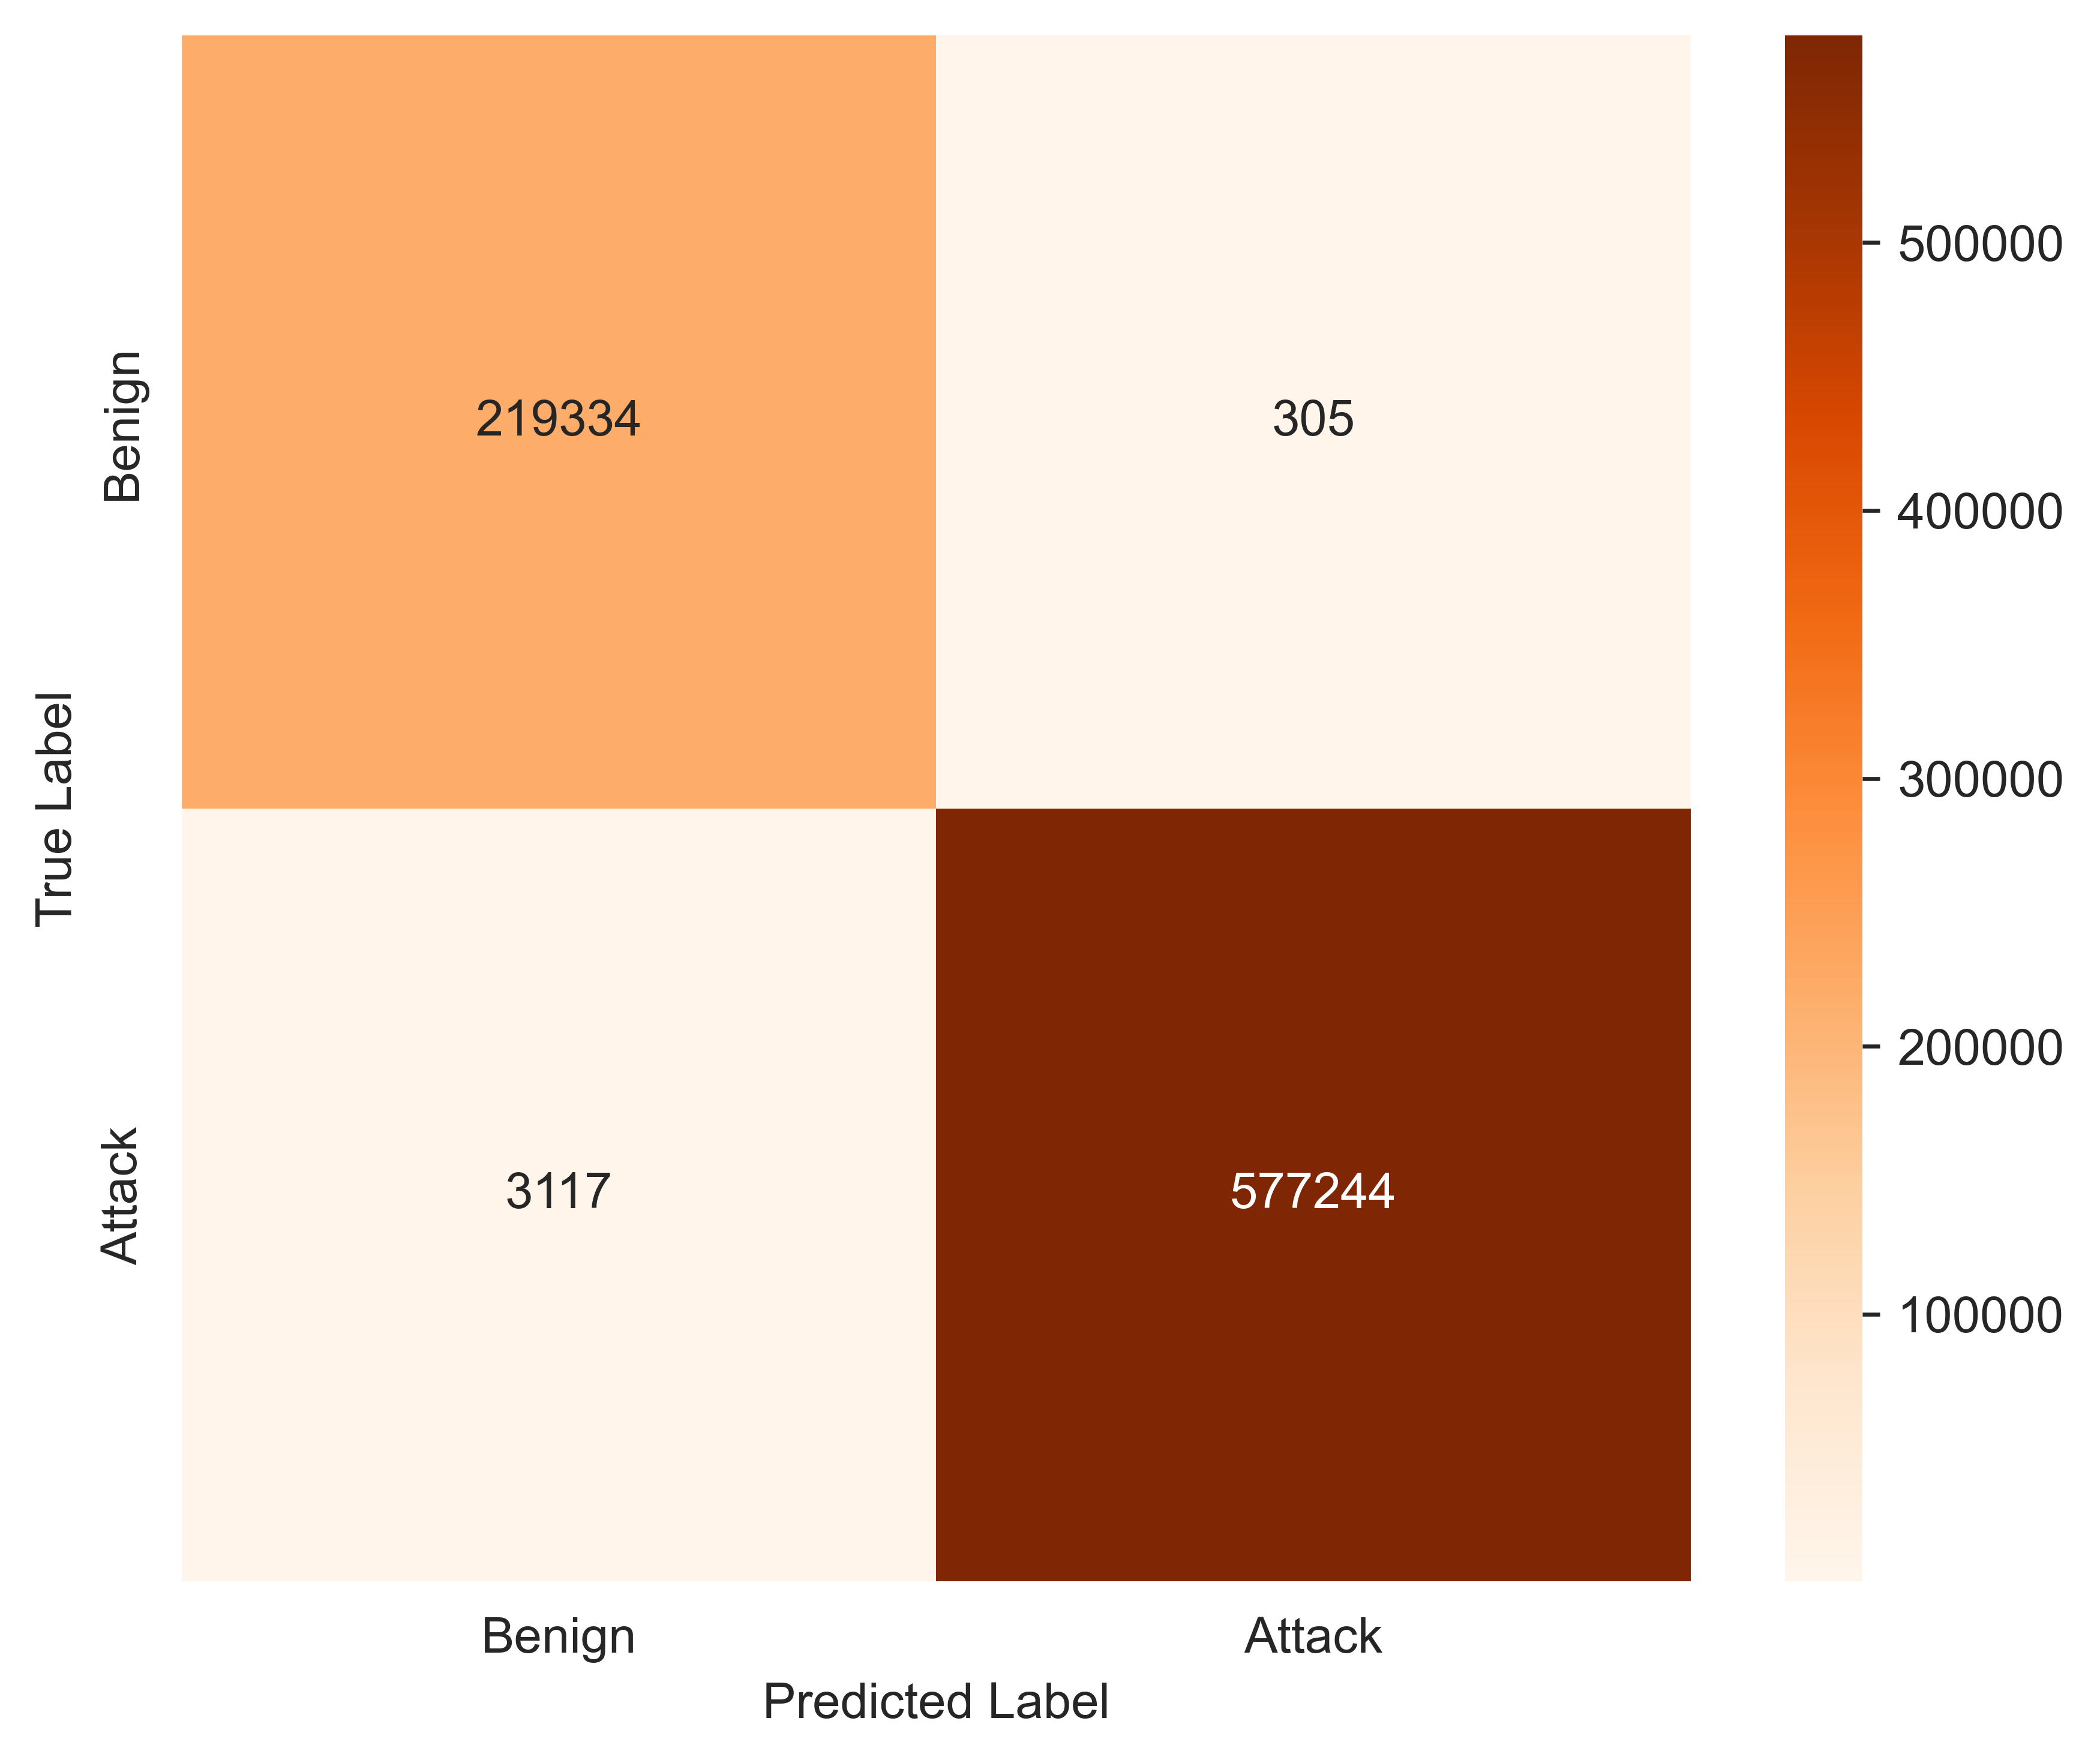

In [15]:
clf_cat = CatBoostClassifier(
    iterations       =500,
    learning_rate    =0.12,
    depth            =14,
    loss_function    ="Logloss",
    eval_metric      ="Logloss",
    scale_pos_weight =scale_pos_weight,
    random_seed      =RANDOM_STATE,
    task_type        ="GPU",
    verbose          =50,
)
clf_cat.fit(X_train, y_train)
evaluate_model(clf_cat, "CatBoost", cmap="Oranges")

# 6.4 NGBoost

NGBoost Accuracy: 99.58%
              precision    recall  f1-score   support

      Benign       0.99      1.00      0.99    219639
      Attack       1.00      0.99      1.00    580361

    accuracy                           1.00    800000
   macro avg       0.99      1.00      0.99    800000
weighted avg       1.00      1.00      1.00    800000



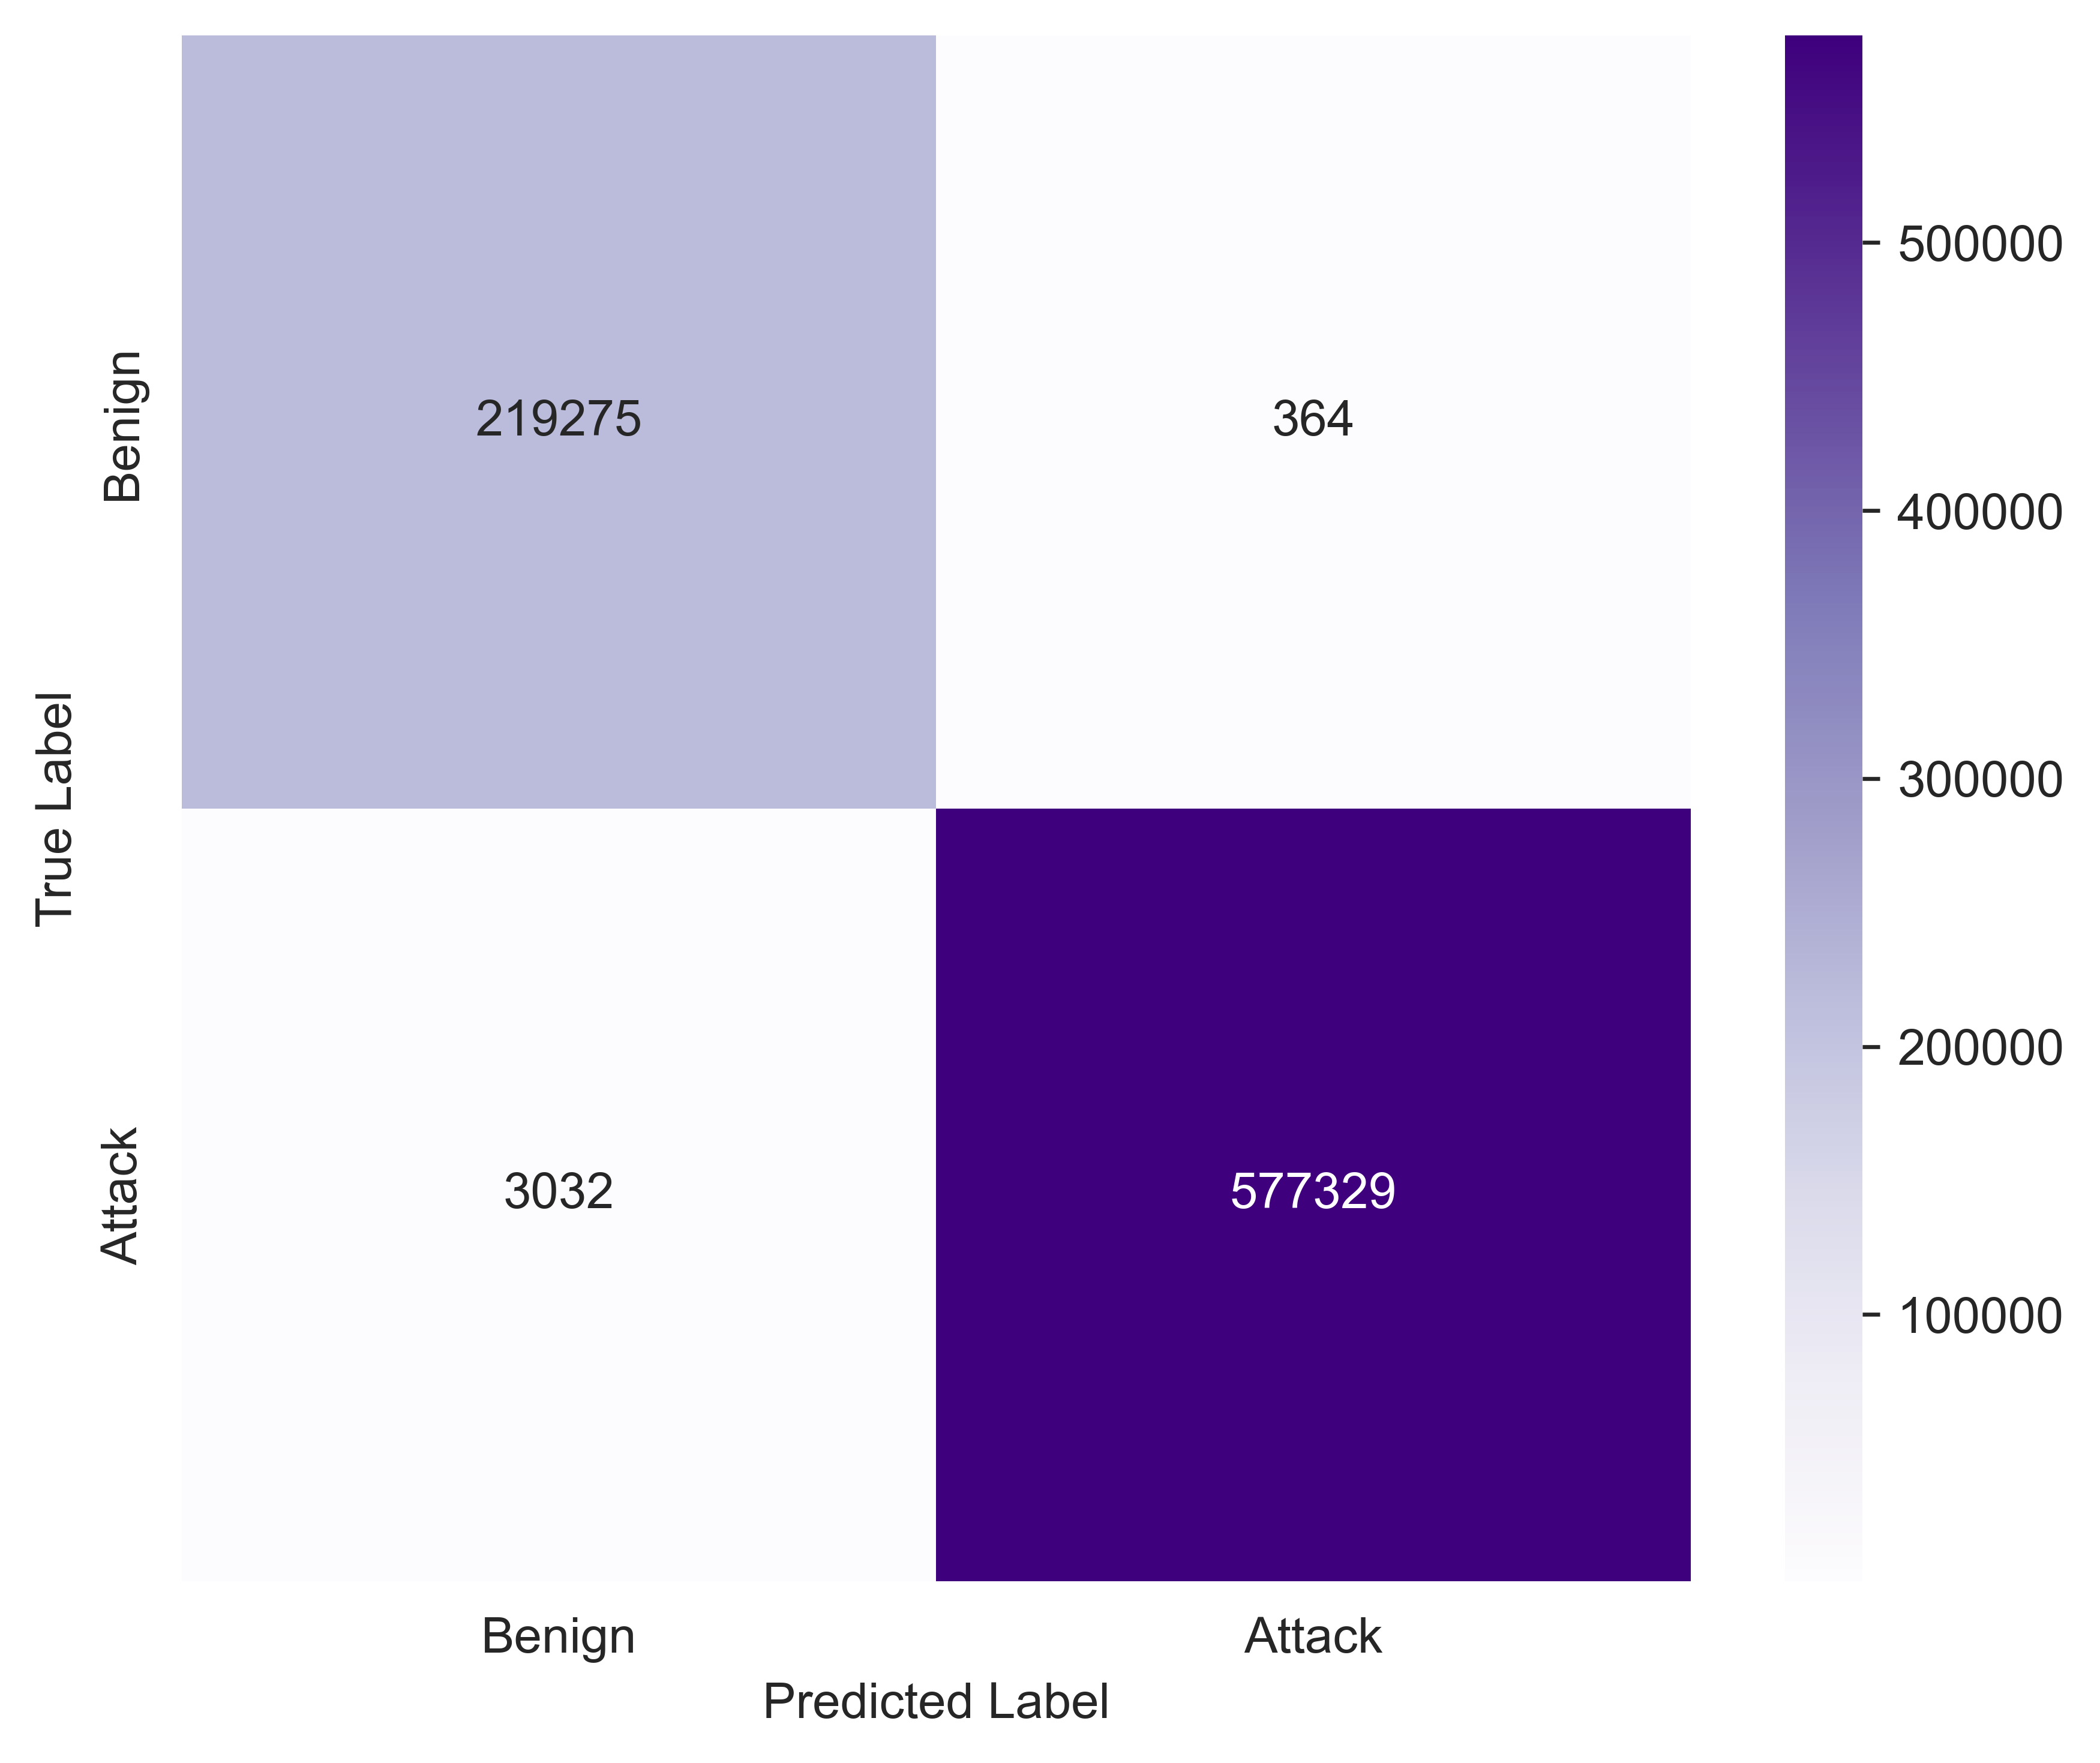

In [16]:
clf_ngb = NGBClassifier(
    Dist             =Bernoulli,
    n_estimators     =100,
    learning_rate    =0.12,
    natural_gradient =False,
    verbose          =False,
    random_state     =RANDOM_STATE
)
clf_ngb.fit(X_train, y_train)
evaluate_model(clf_ngb, "NGBoost", cmap="Purples")

# 6.5 ExtraTrees + LogisticRegression

ExtraTrees Accuracy: 98.92%
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98    219639
      Attack       1.00      0.99      0.99    580361

    accuracy                           0.99    800000
   macro avg       0.98      0.99      0.99    800000
weighted avg       0.99      0.99      0.99    800000



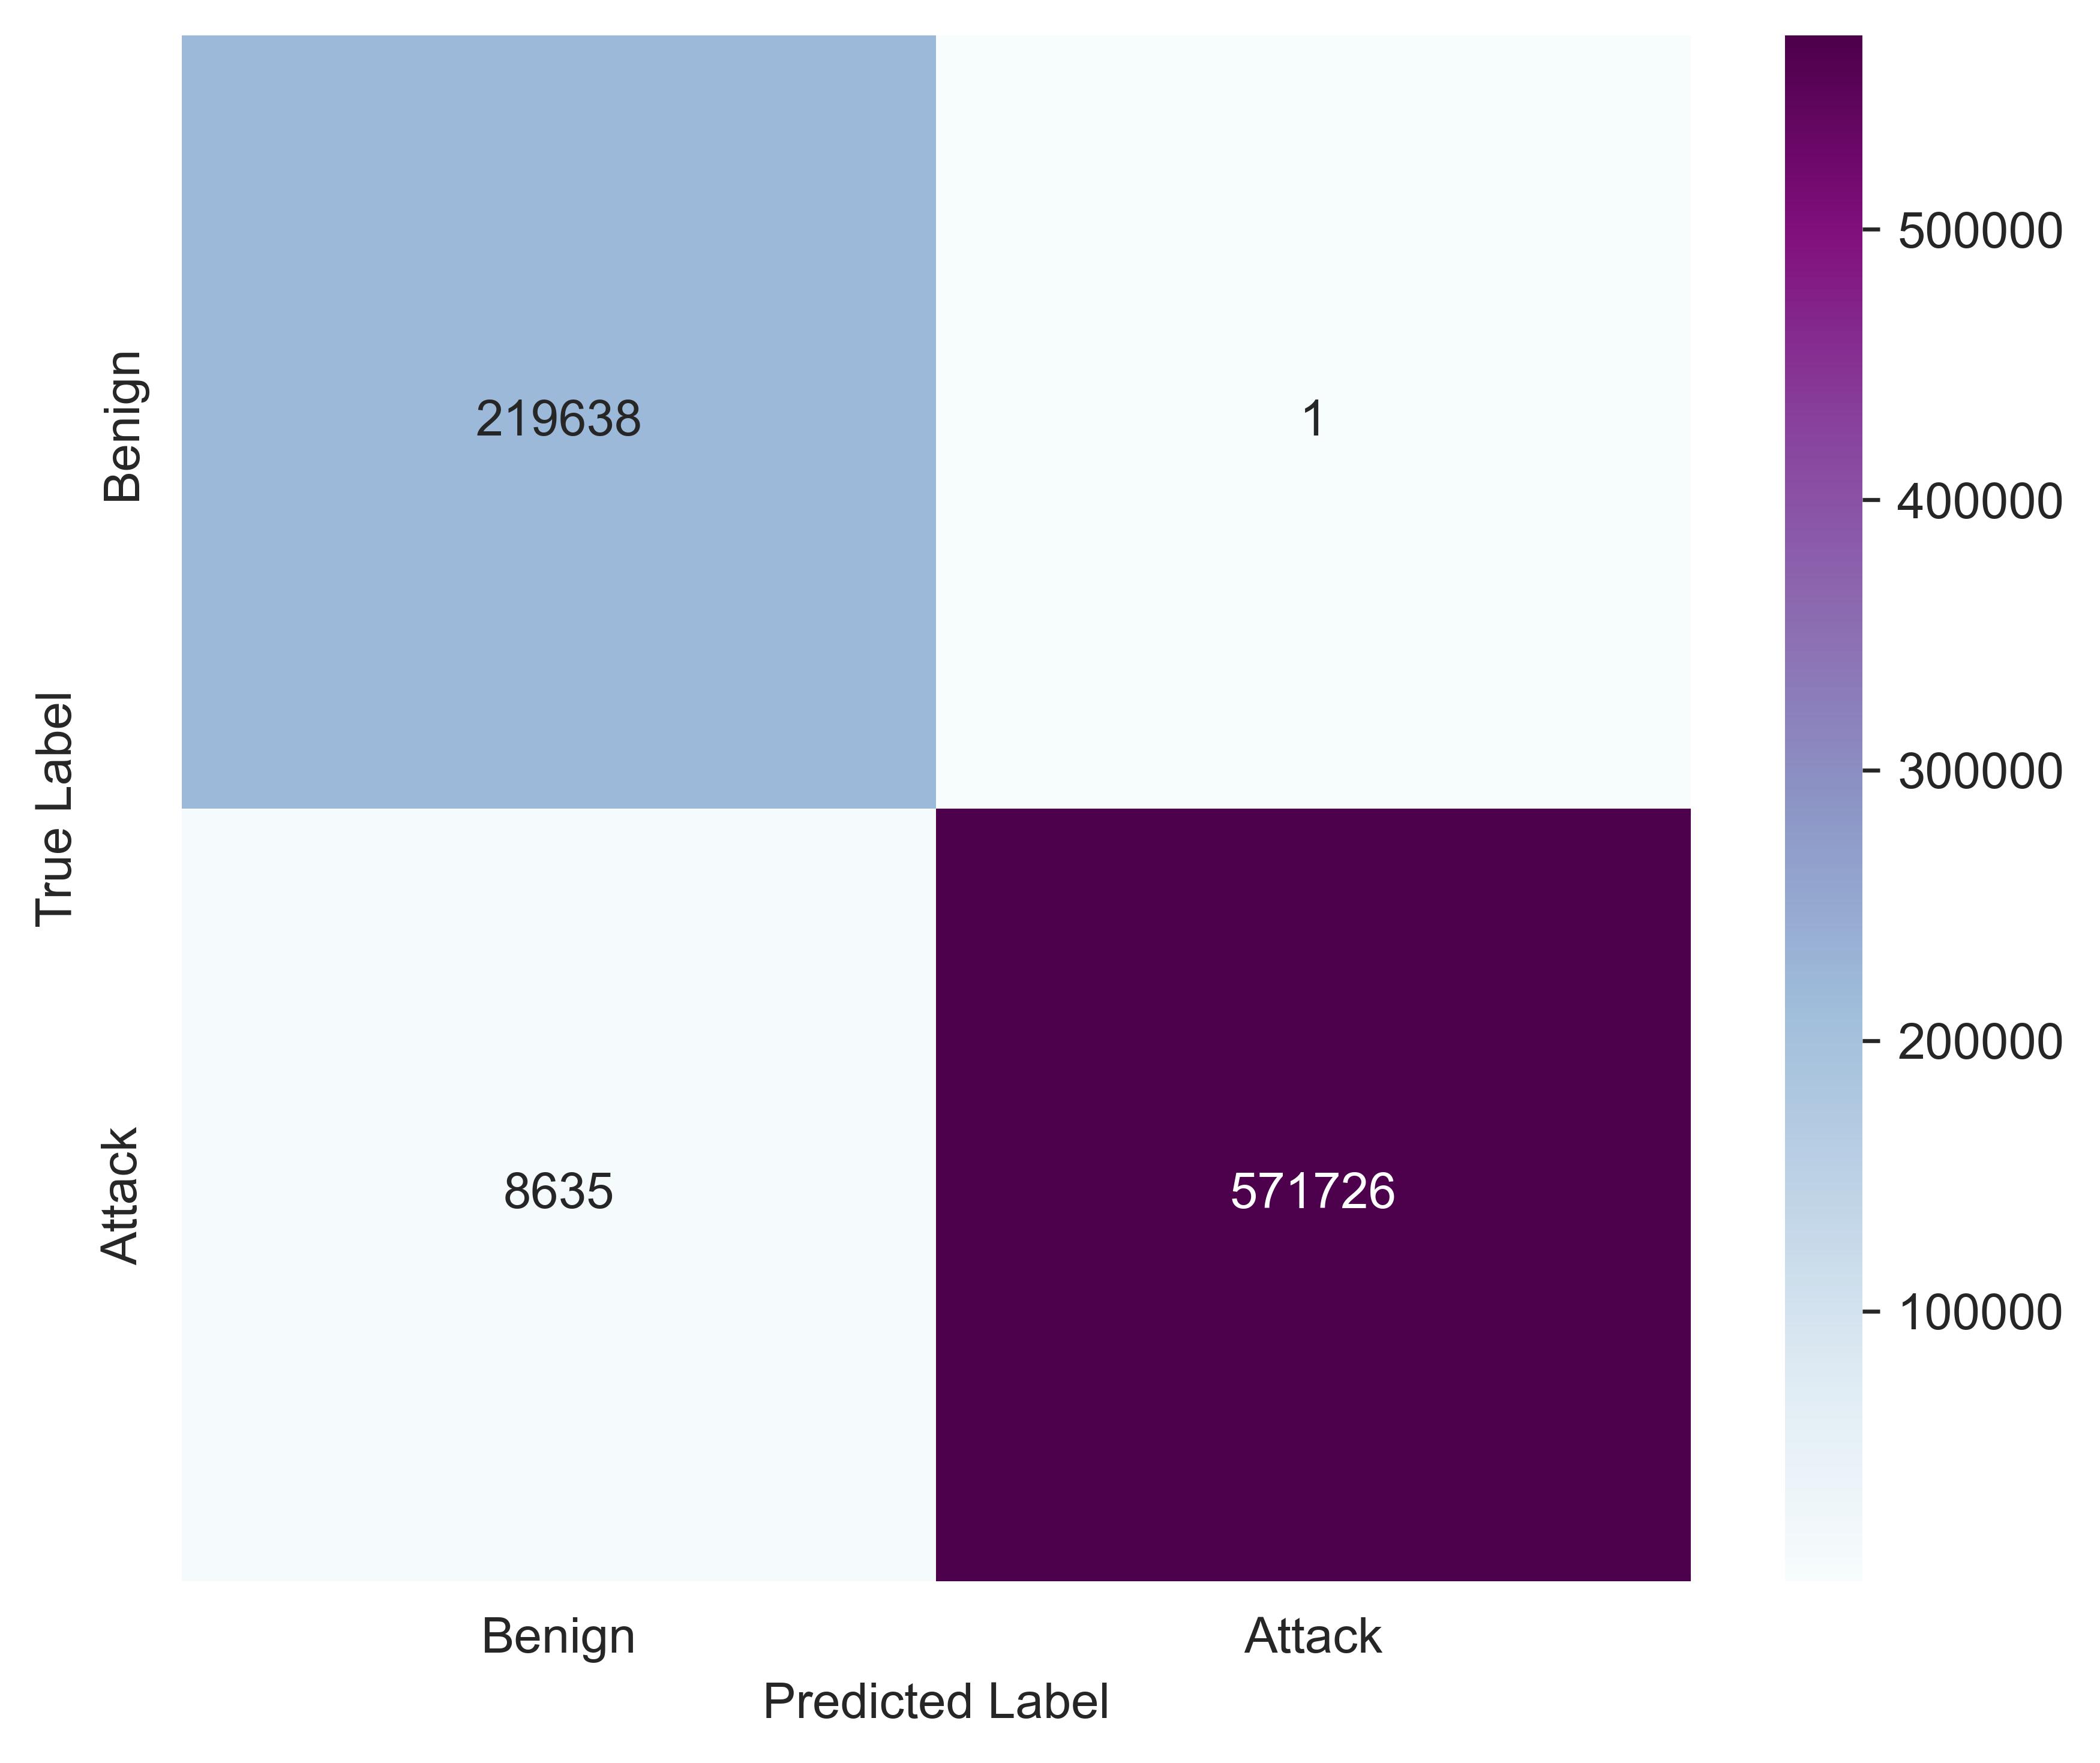

LogisticRegression Accuracy: 98.22%
              precision    recall  f1-score   support

      Benign       0.95      0.99      0.97    219639
      Attack       1.00      0.98      0.99    580361

    accuracy                           0.98    800000
   macro avg       0.97      0.98      0.98    800000
weighted avg       0.98      0.98      0.98    800000



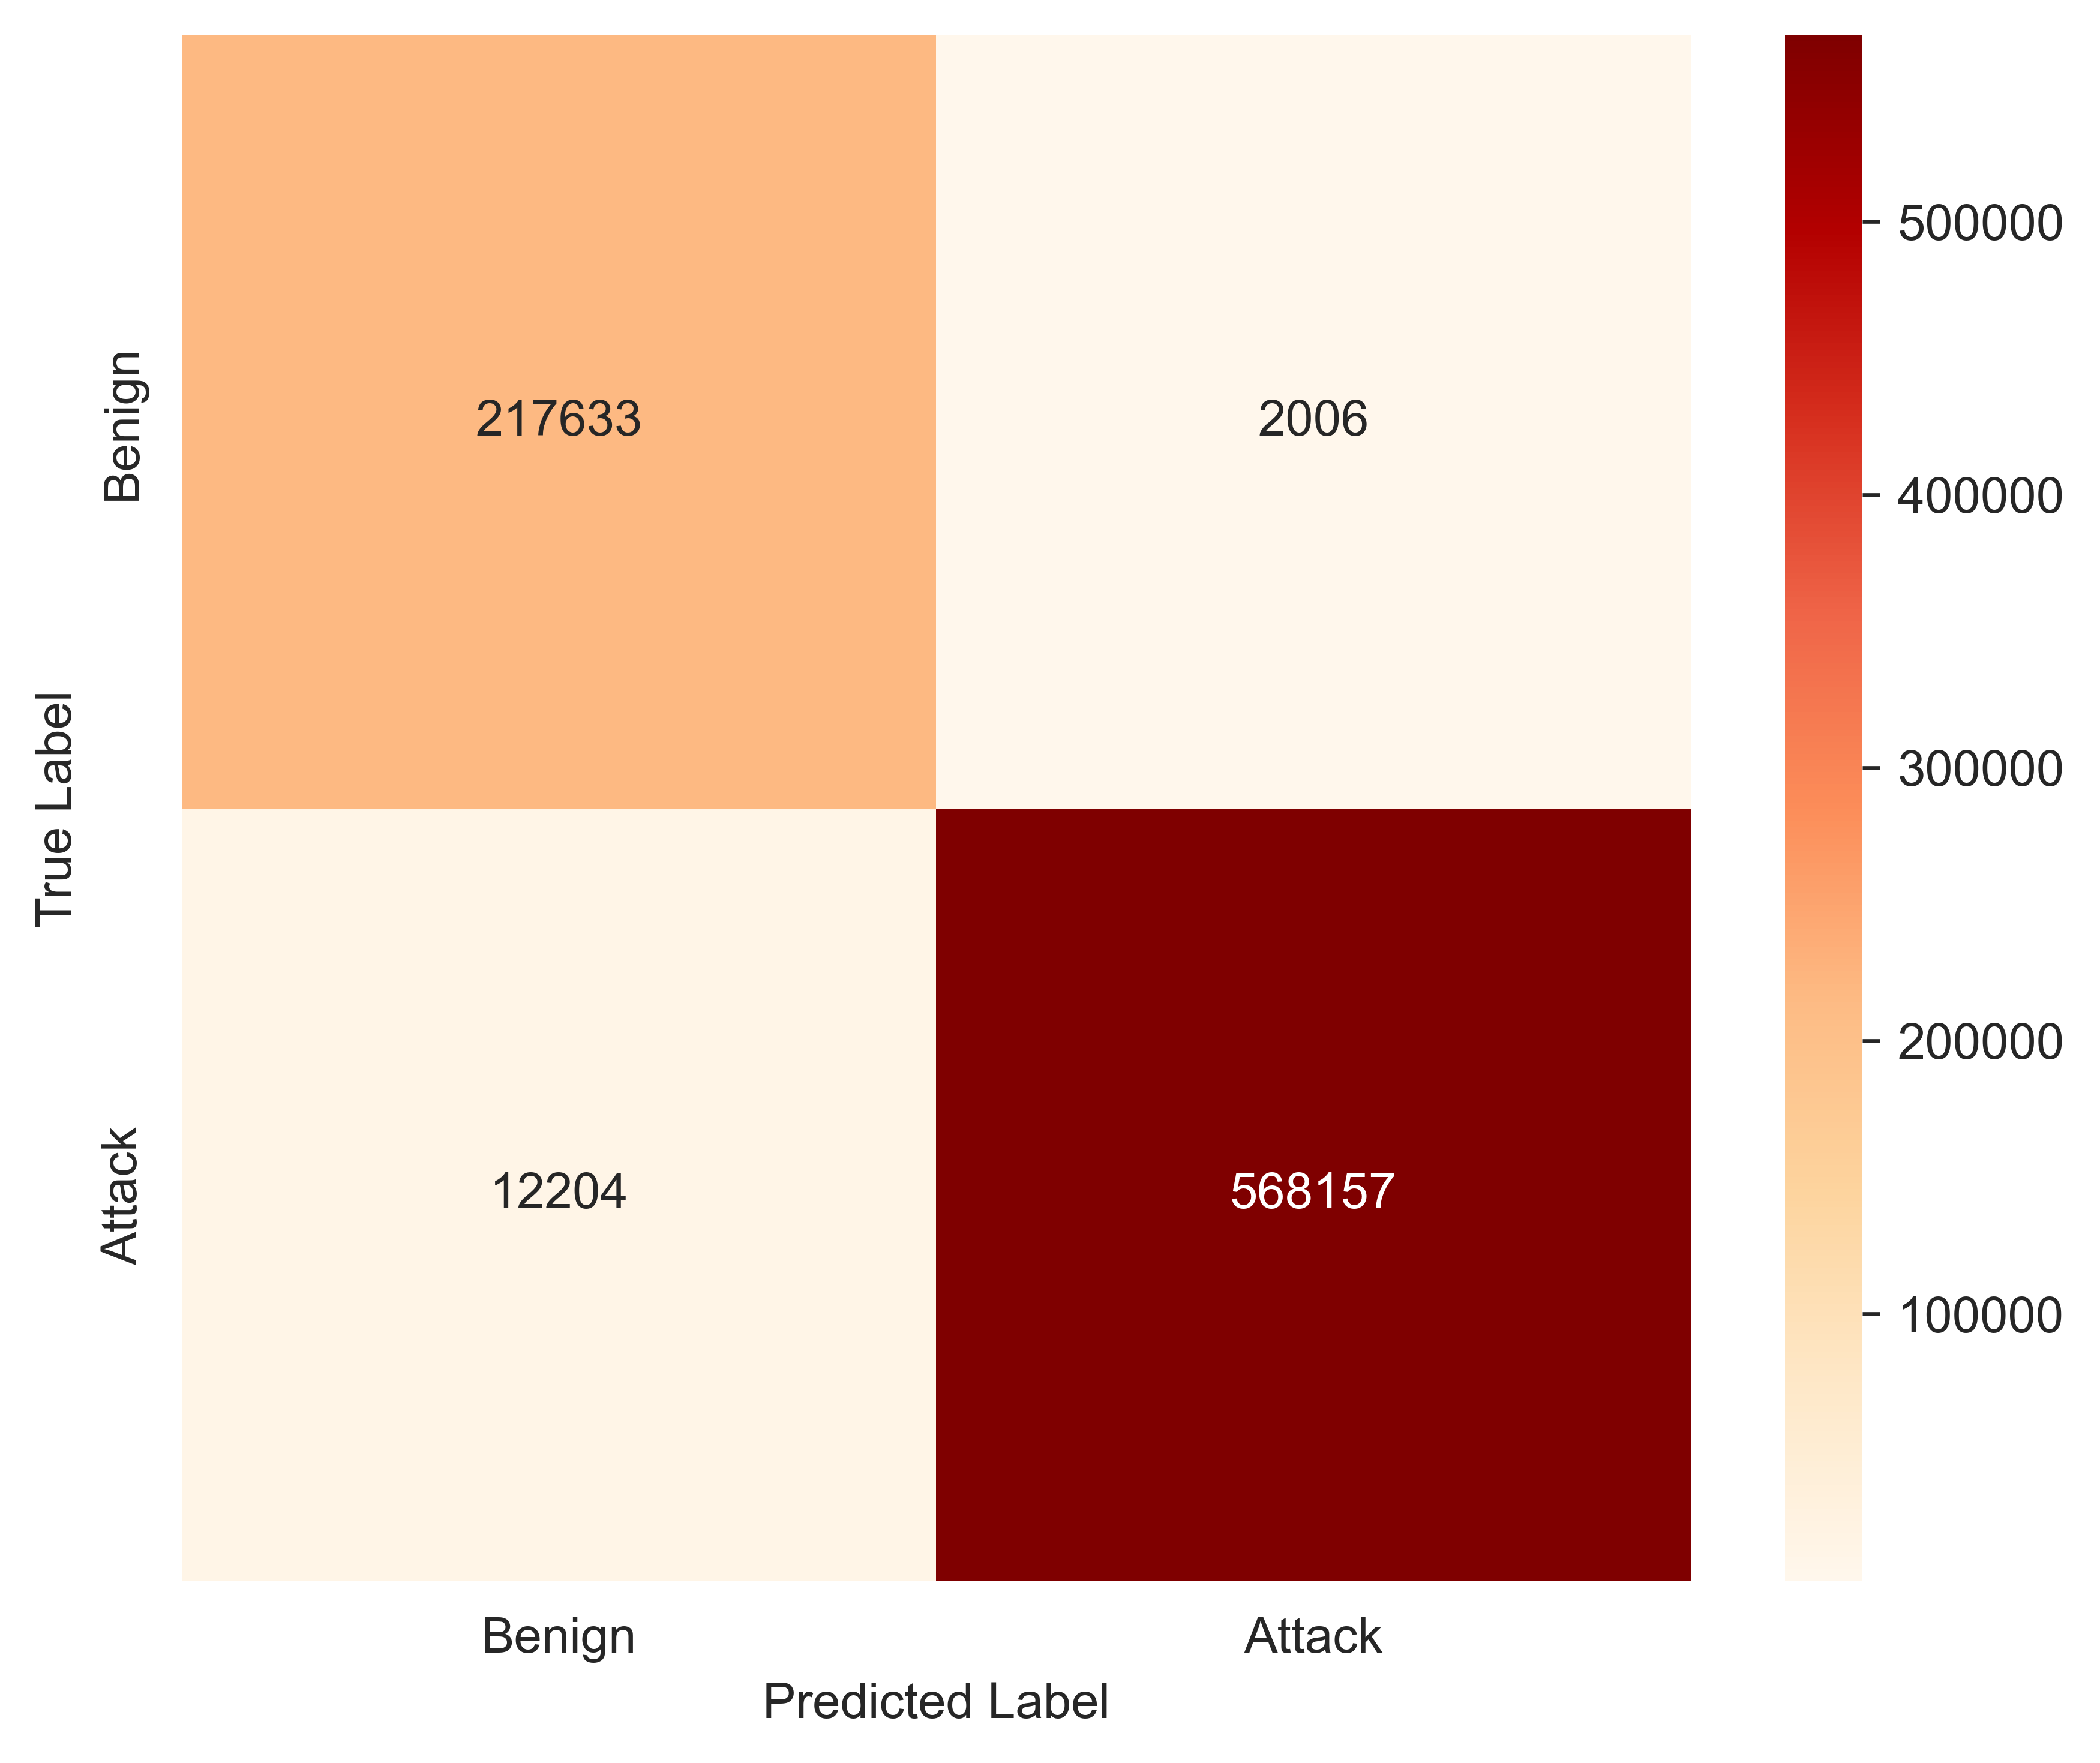

In [45]:

models = [
    (ExtraTreesClassifier(
        n_estimators=300, max_depth=14,
        class_weight="balanced", n_jobs=-1,
        random_state=RANDOM_STATE
     ), "ExtraTrees", "BuPu"),
    (LogisticRegression(
        class_weight="balanced", max_iter=500,
        random_state=RANDOM_STATE
     ), "LogisticRegression", "OrRd"),
]
for mdl, name, cmap in models:
    mdl.fit(X_train, y_train)
    evaluate_model(mdl, name, cmap=cmap)

# ### 6.6) Baseline Traditional ML Classifiers

Decision Tree Accuracy: 99.49%
              precision    recall  f1-score   support

      Benign       0.98      1.00      0.99    219639
      Attack       1.00      0.99      1.00    580361

    accuracy                           0.99    800000
   macro avg       0.99      1.00      0.99    800000
weighted avg       0.99      0.99      0.99    800000



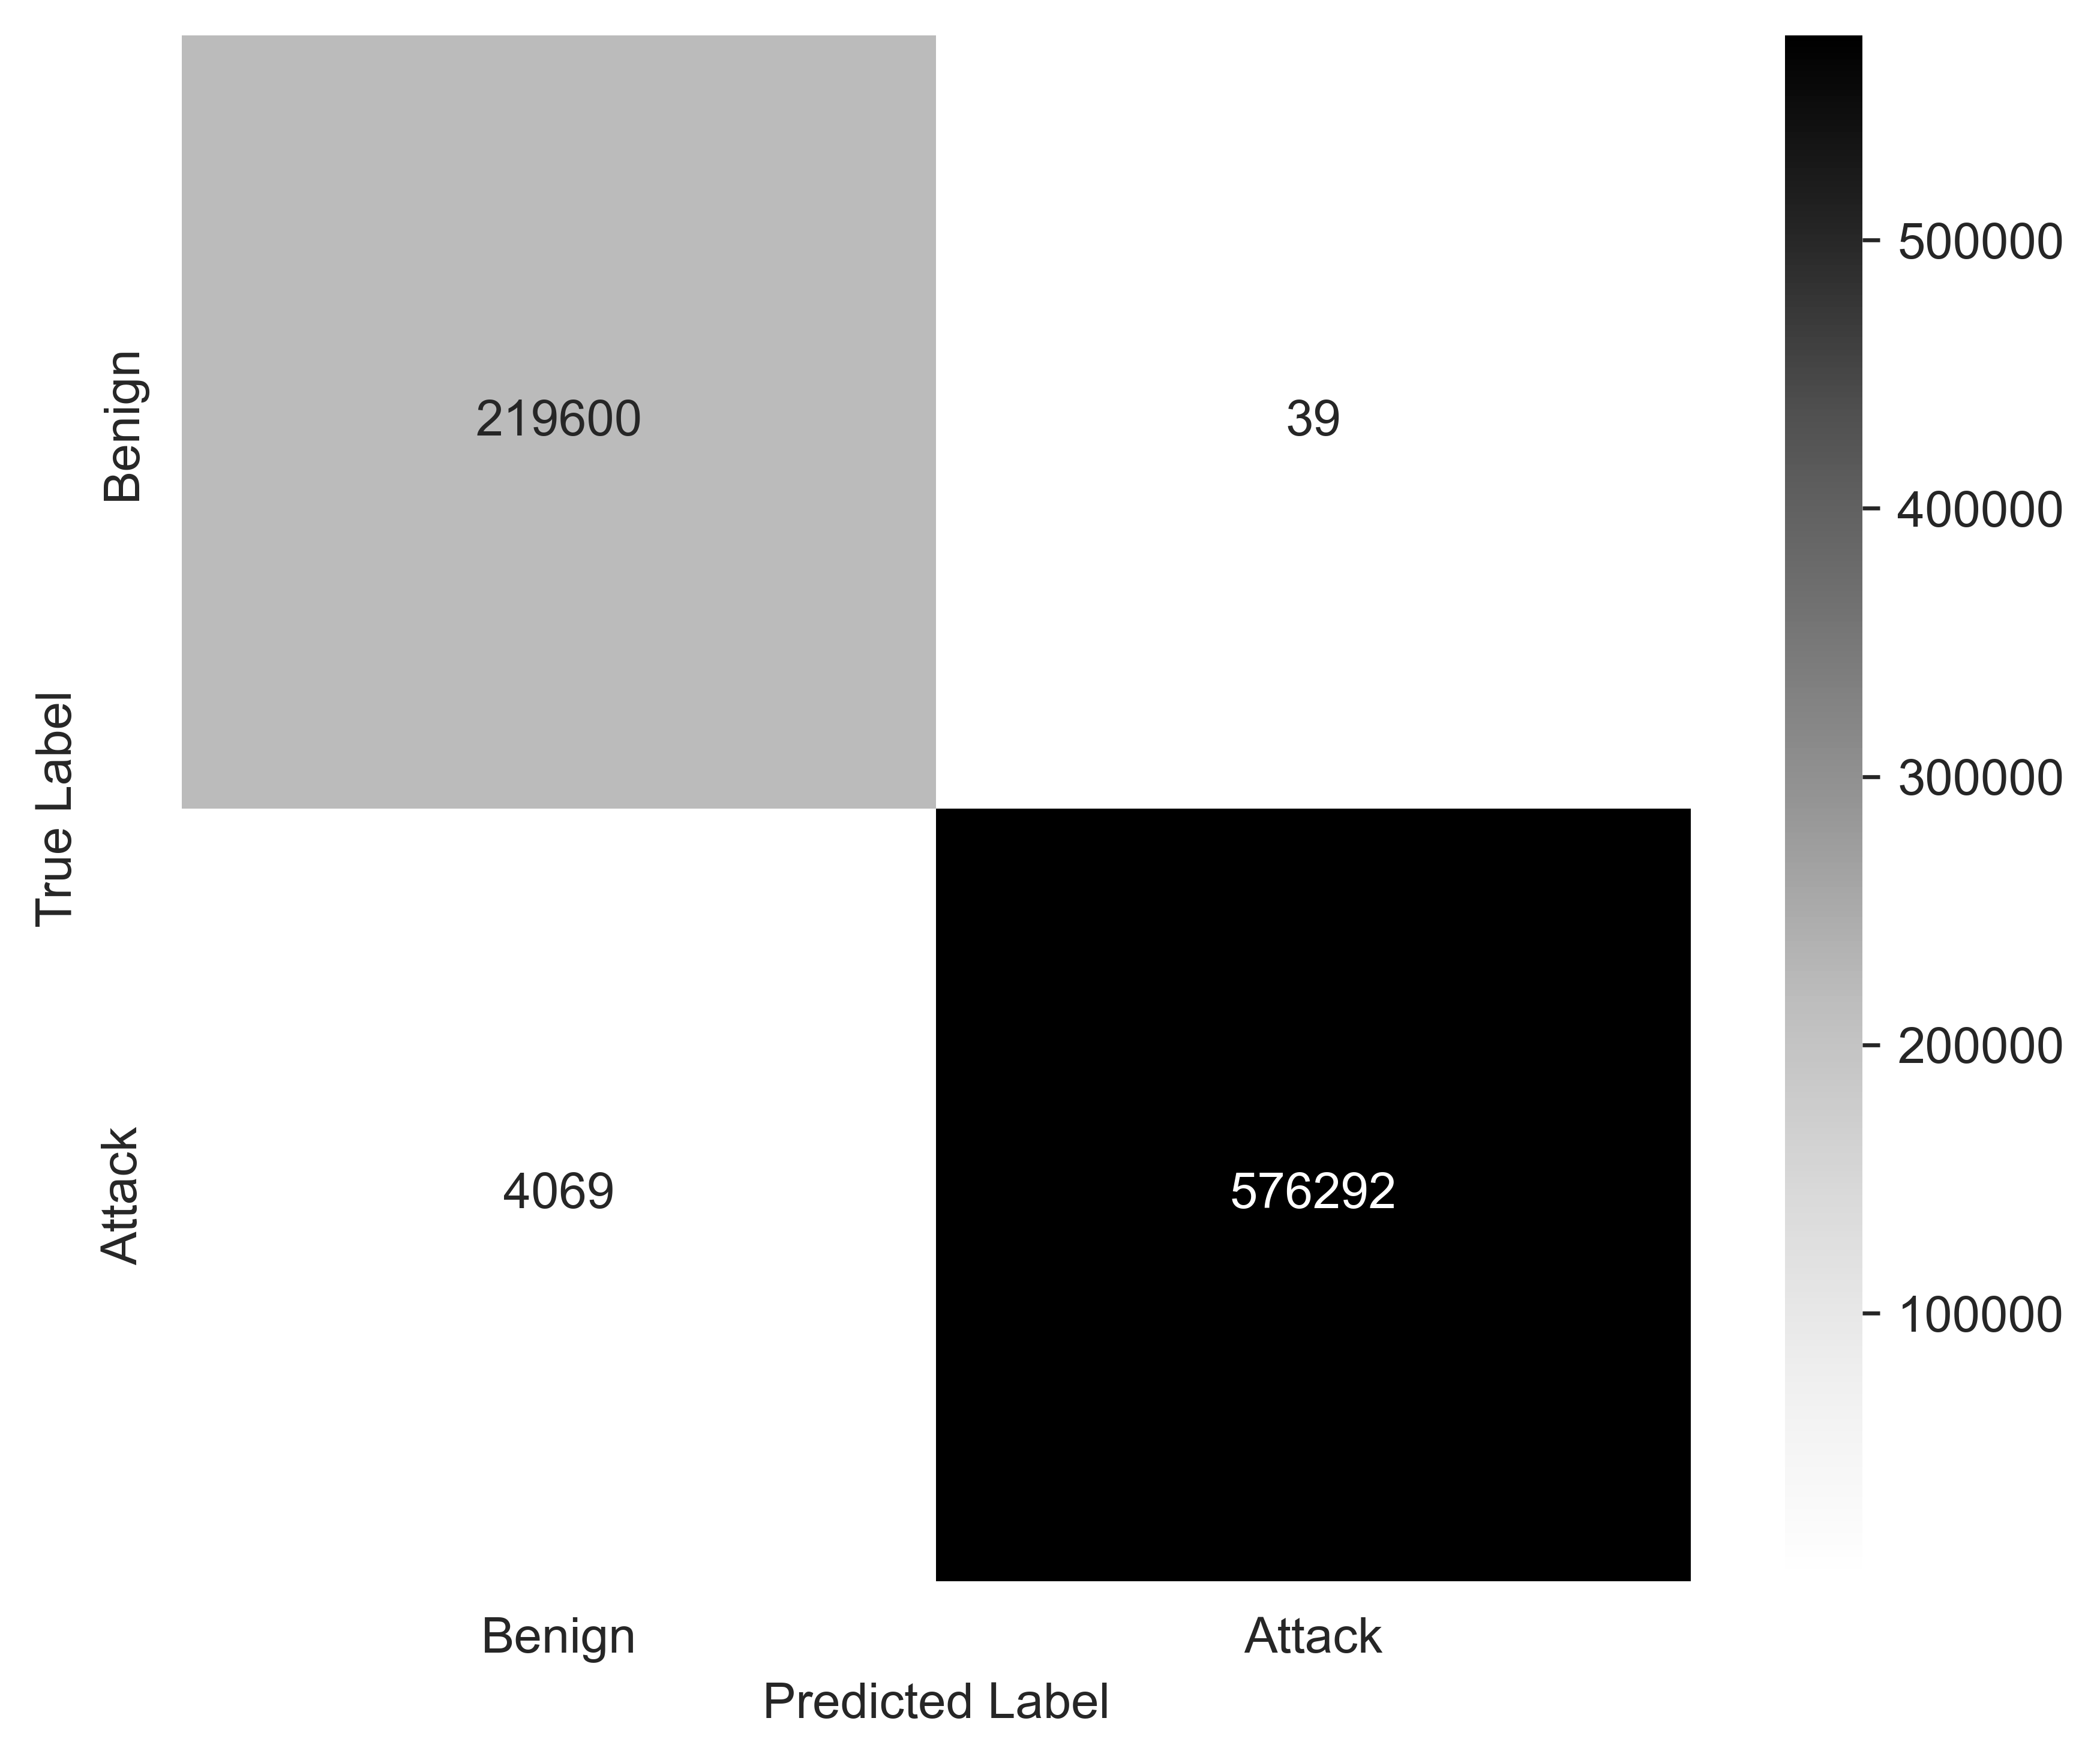

Random Forest Accuracy: 99.55%
              precision    recall  f1-score   support

      Benign       0.98      1.00      0.99    219639
      Attack       1.00      0.99      1.00    580361

    accuracy                           1.00    800000
   macro avg       0.99      1.00      0.99    800000
weighted avg       1.00      1.00      1.00    800000



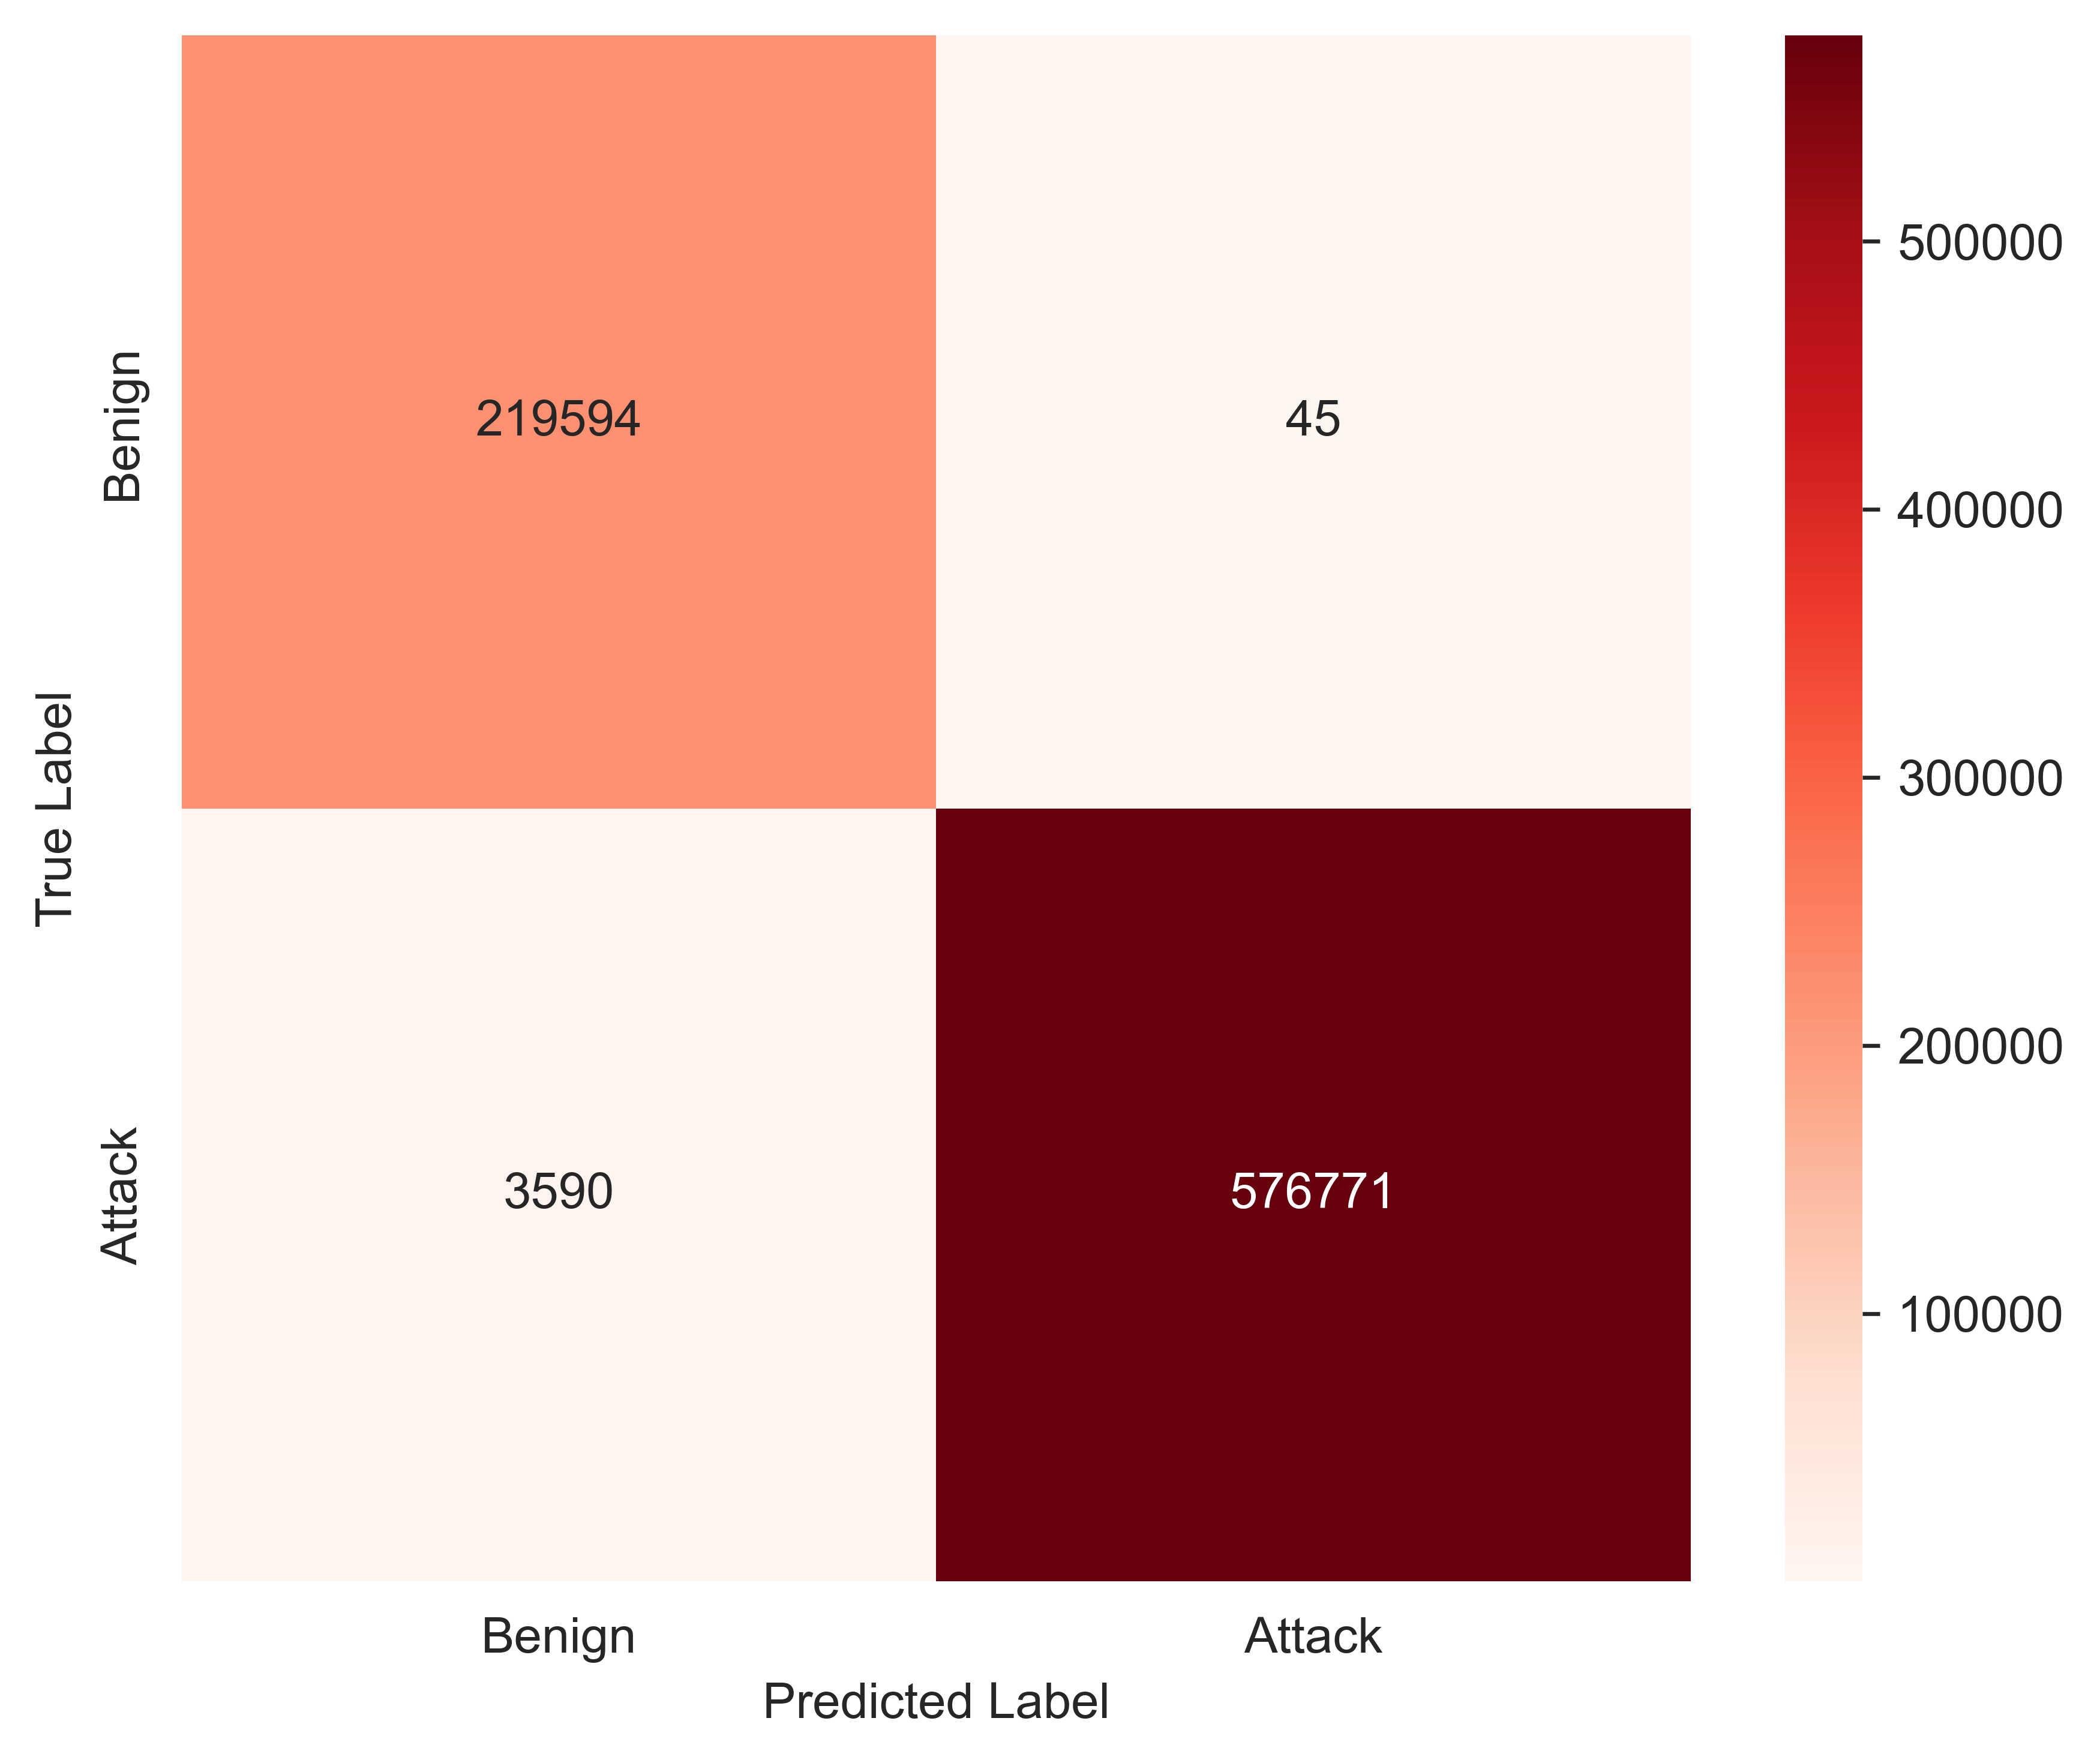

C:\Users\ss160\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression Accuracy: 98.22%
              precision    recall  f1-score   support

      Benign       0.95      0.99      0.97    219639
      Attack       1.00      0.98      0.99    580361

    accuracy                           0.98    800000
   macro avg       0.97      0.98      0.98    800000
weighted avg       0.98      0.98      0.98    800000



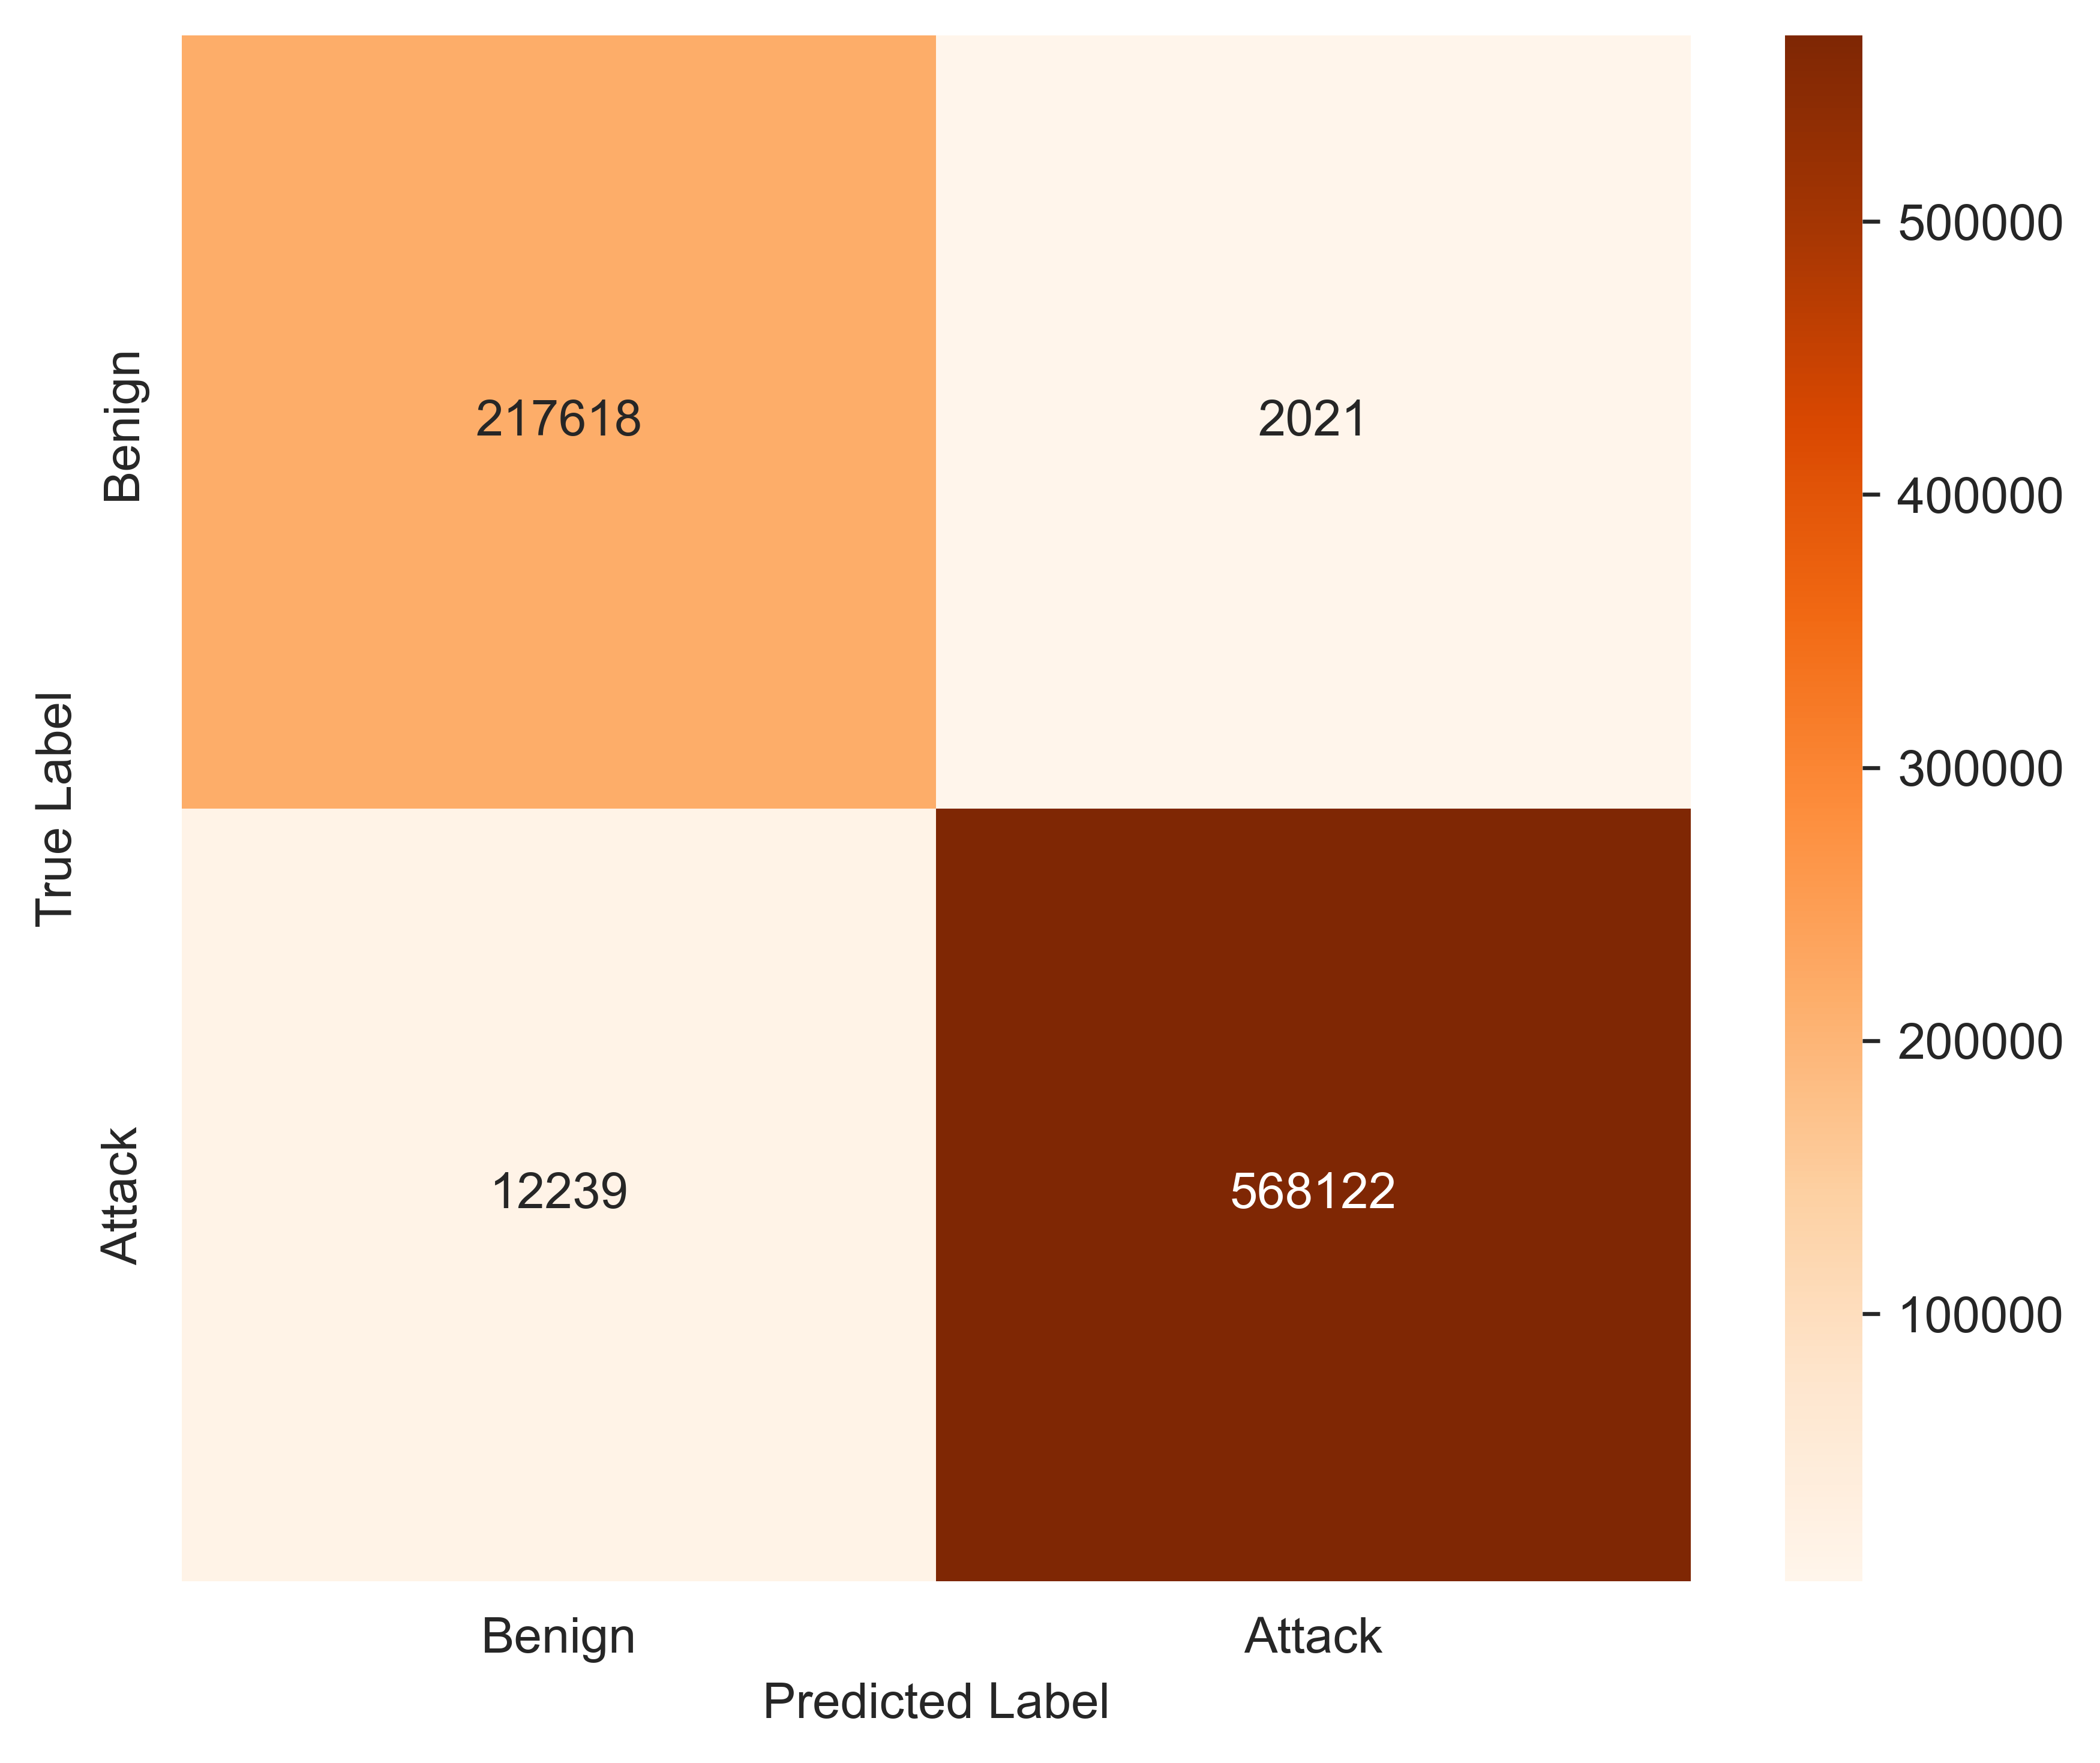

Linear SVM (SGD) Accuracy: 98.21%
              precision    recall  f1-score   support

      Benign       0.95      0.99      0.97    219639
      Attack       1.00      0.98      0.99    580361

    accuracy                           0.98    800000
   macro avg       0.97      0.99      0.98    800000
weighted avg       0.98      0.98      0.98    800000



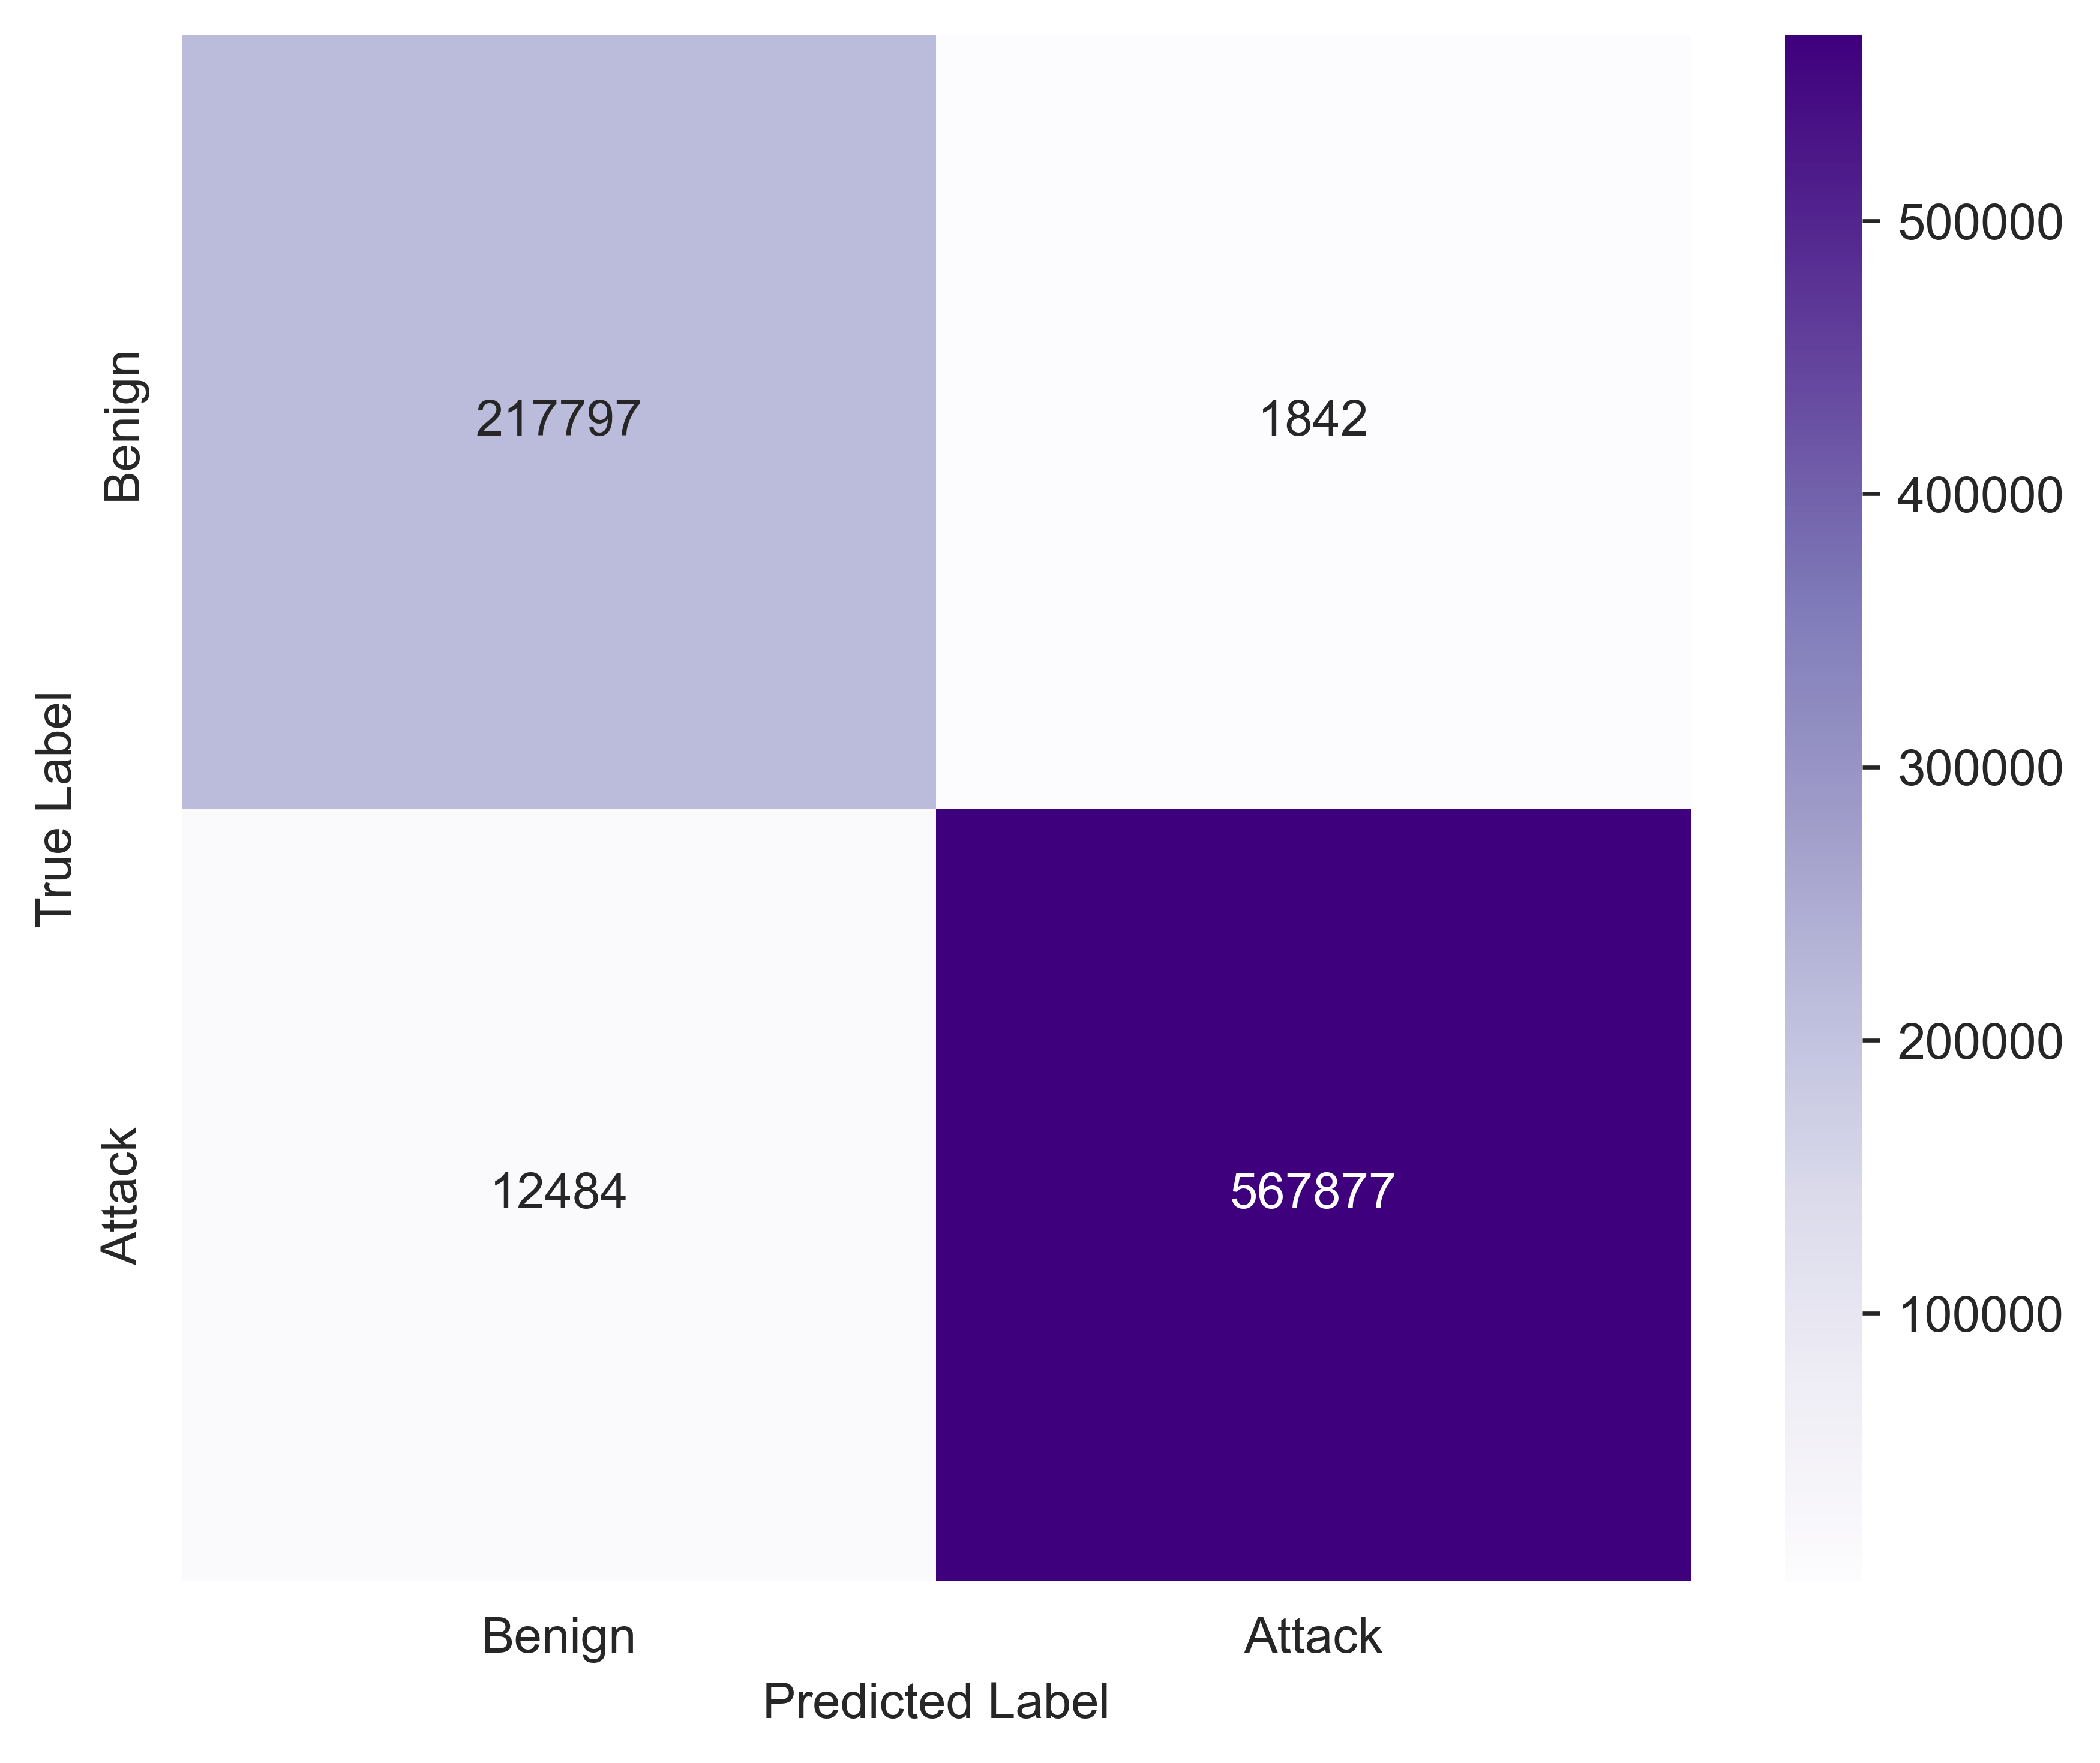

k-NN (subsampled) Accuracy: 99.02%
              precision    recall  f1-score   support

      Benign       0.97      1.00      0.98    219639
      Attack       1.00      0.99      0.99    580361

    accuracy                           0.99    800000
   macro avg       0.98      0.99      0.99    800000
weighted avg       0.99      0.99      0.99    800000



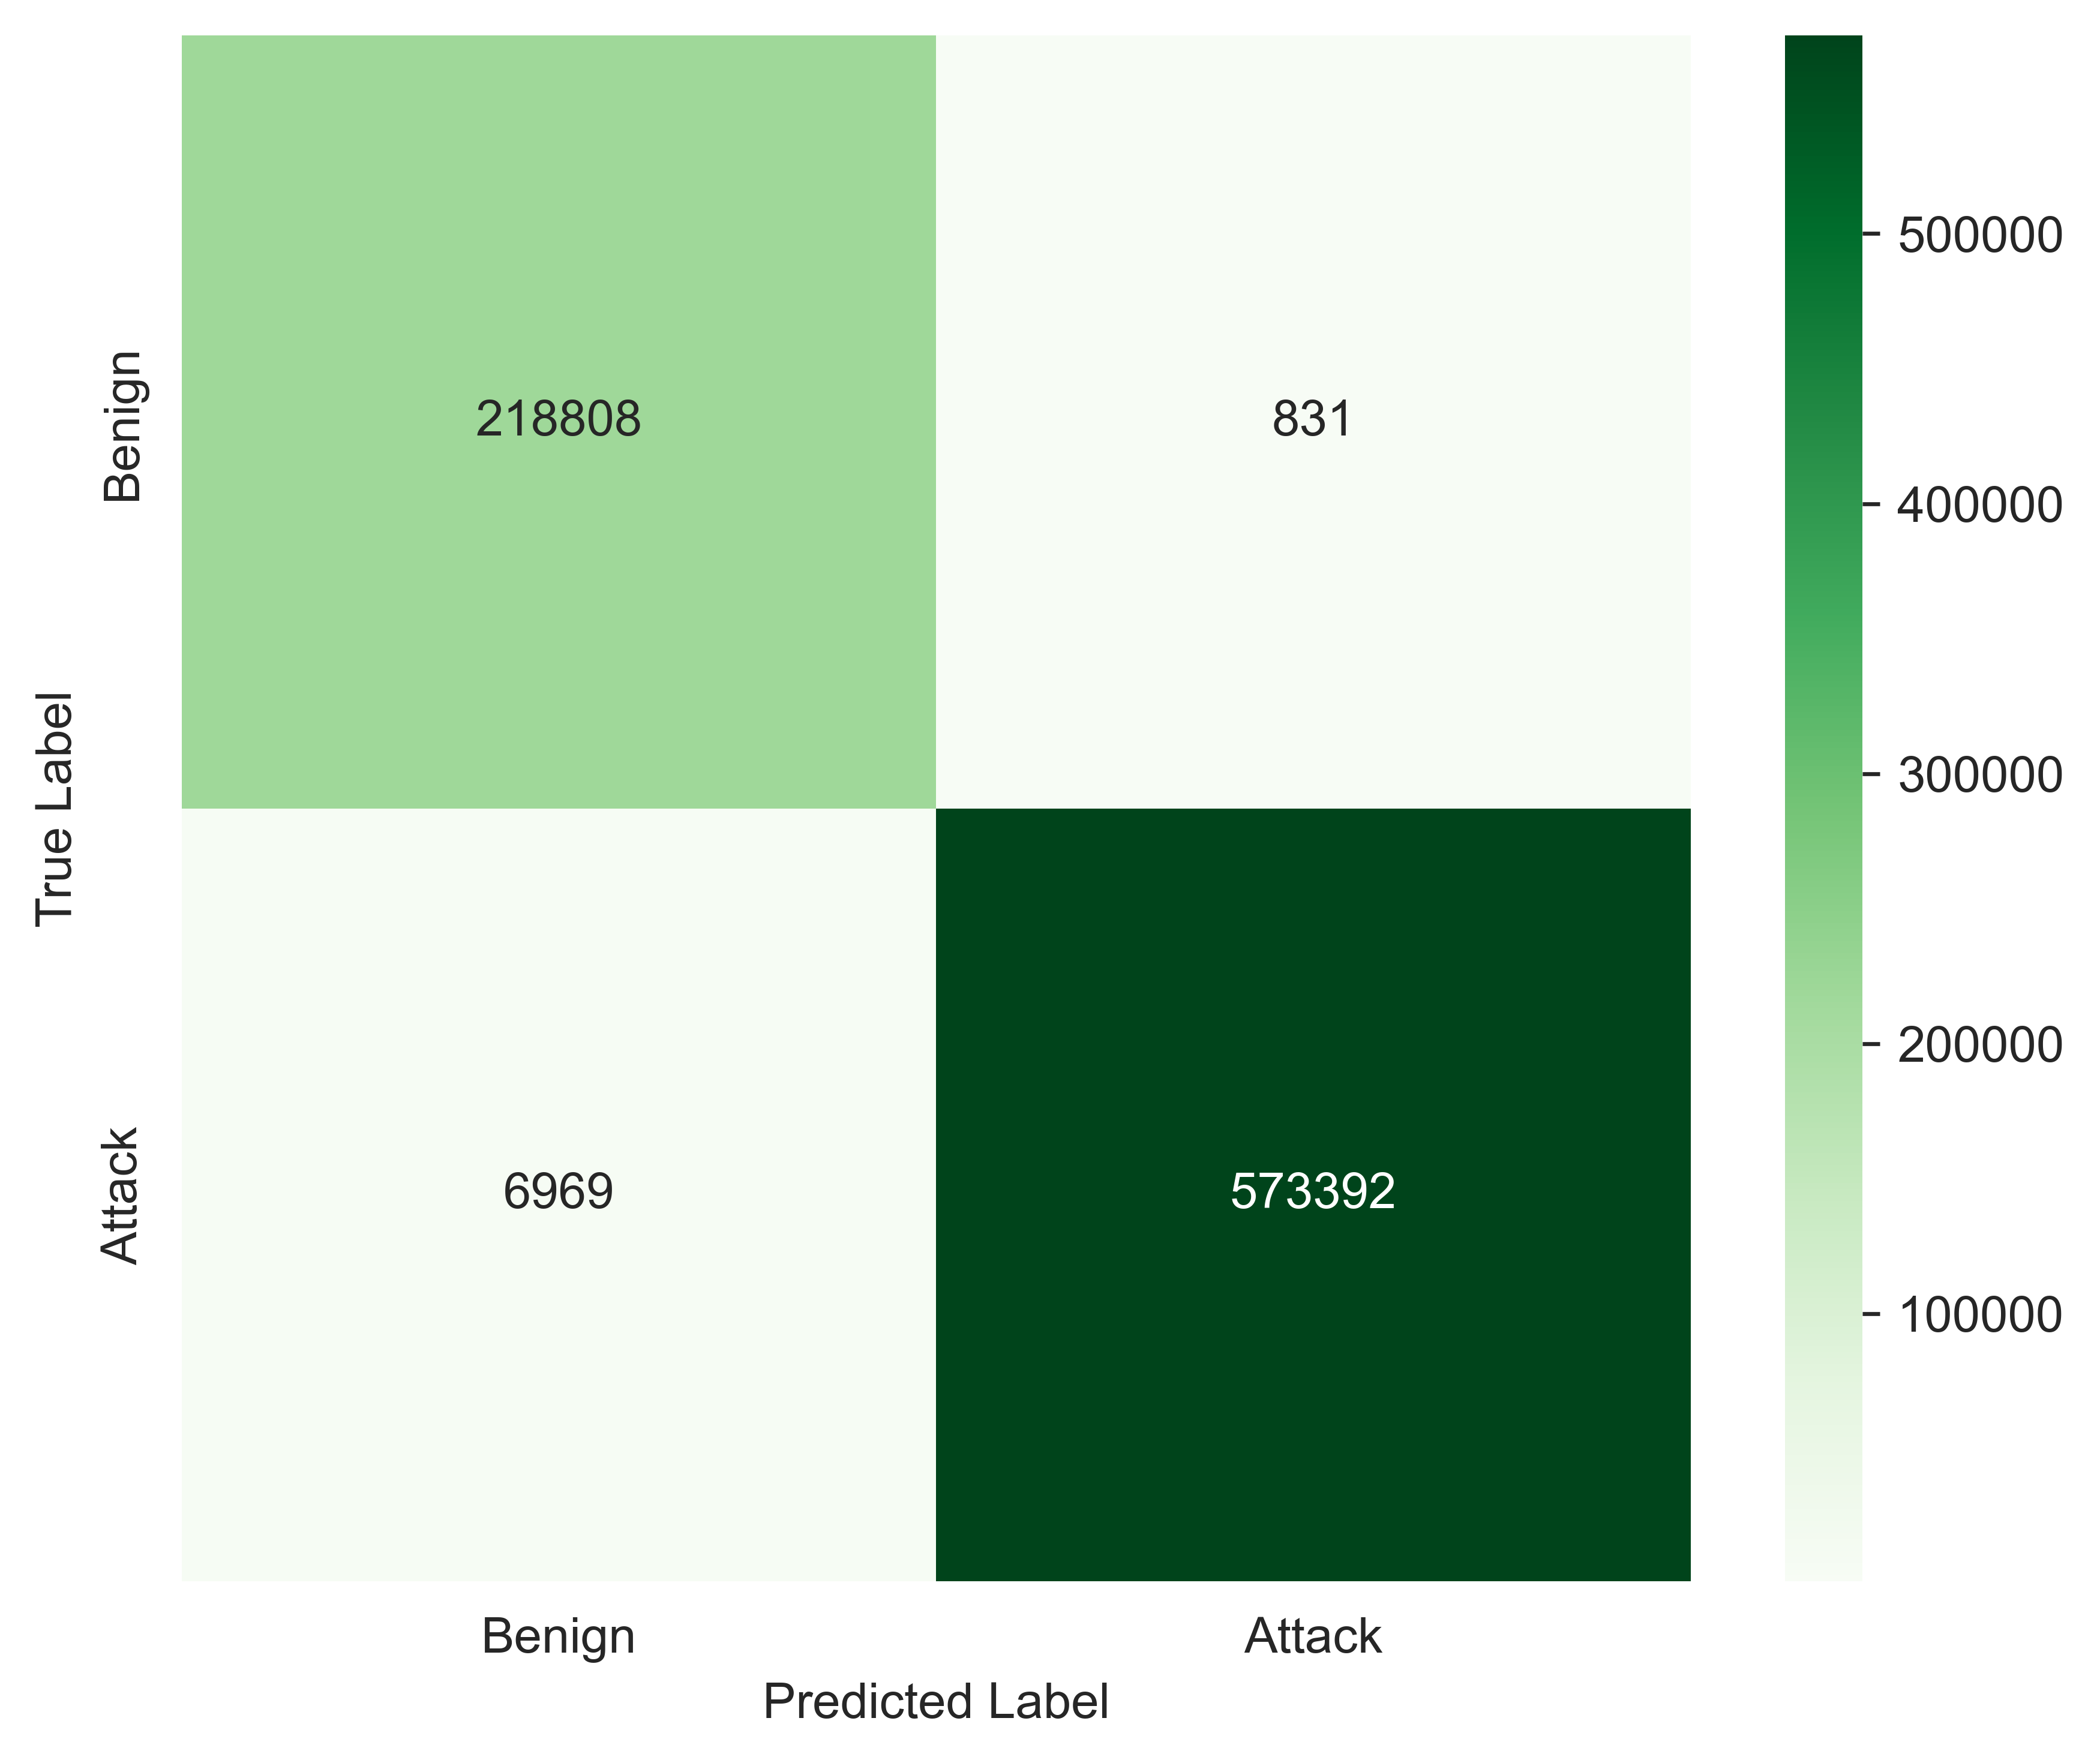

Gaussian Naive Bayes Accuracy: 96.64%
              precision    recall  f1-score   support

      Benign       0.89      1.00      0.94    219639
      Attack       1.00      0.95      0.98    580361

    accuracy                           0.97    800000
   macro avg       0.95      0.98      0.96    800000
weighted avg       0.97      0.97      0.97    800000



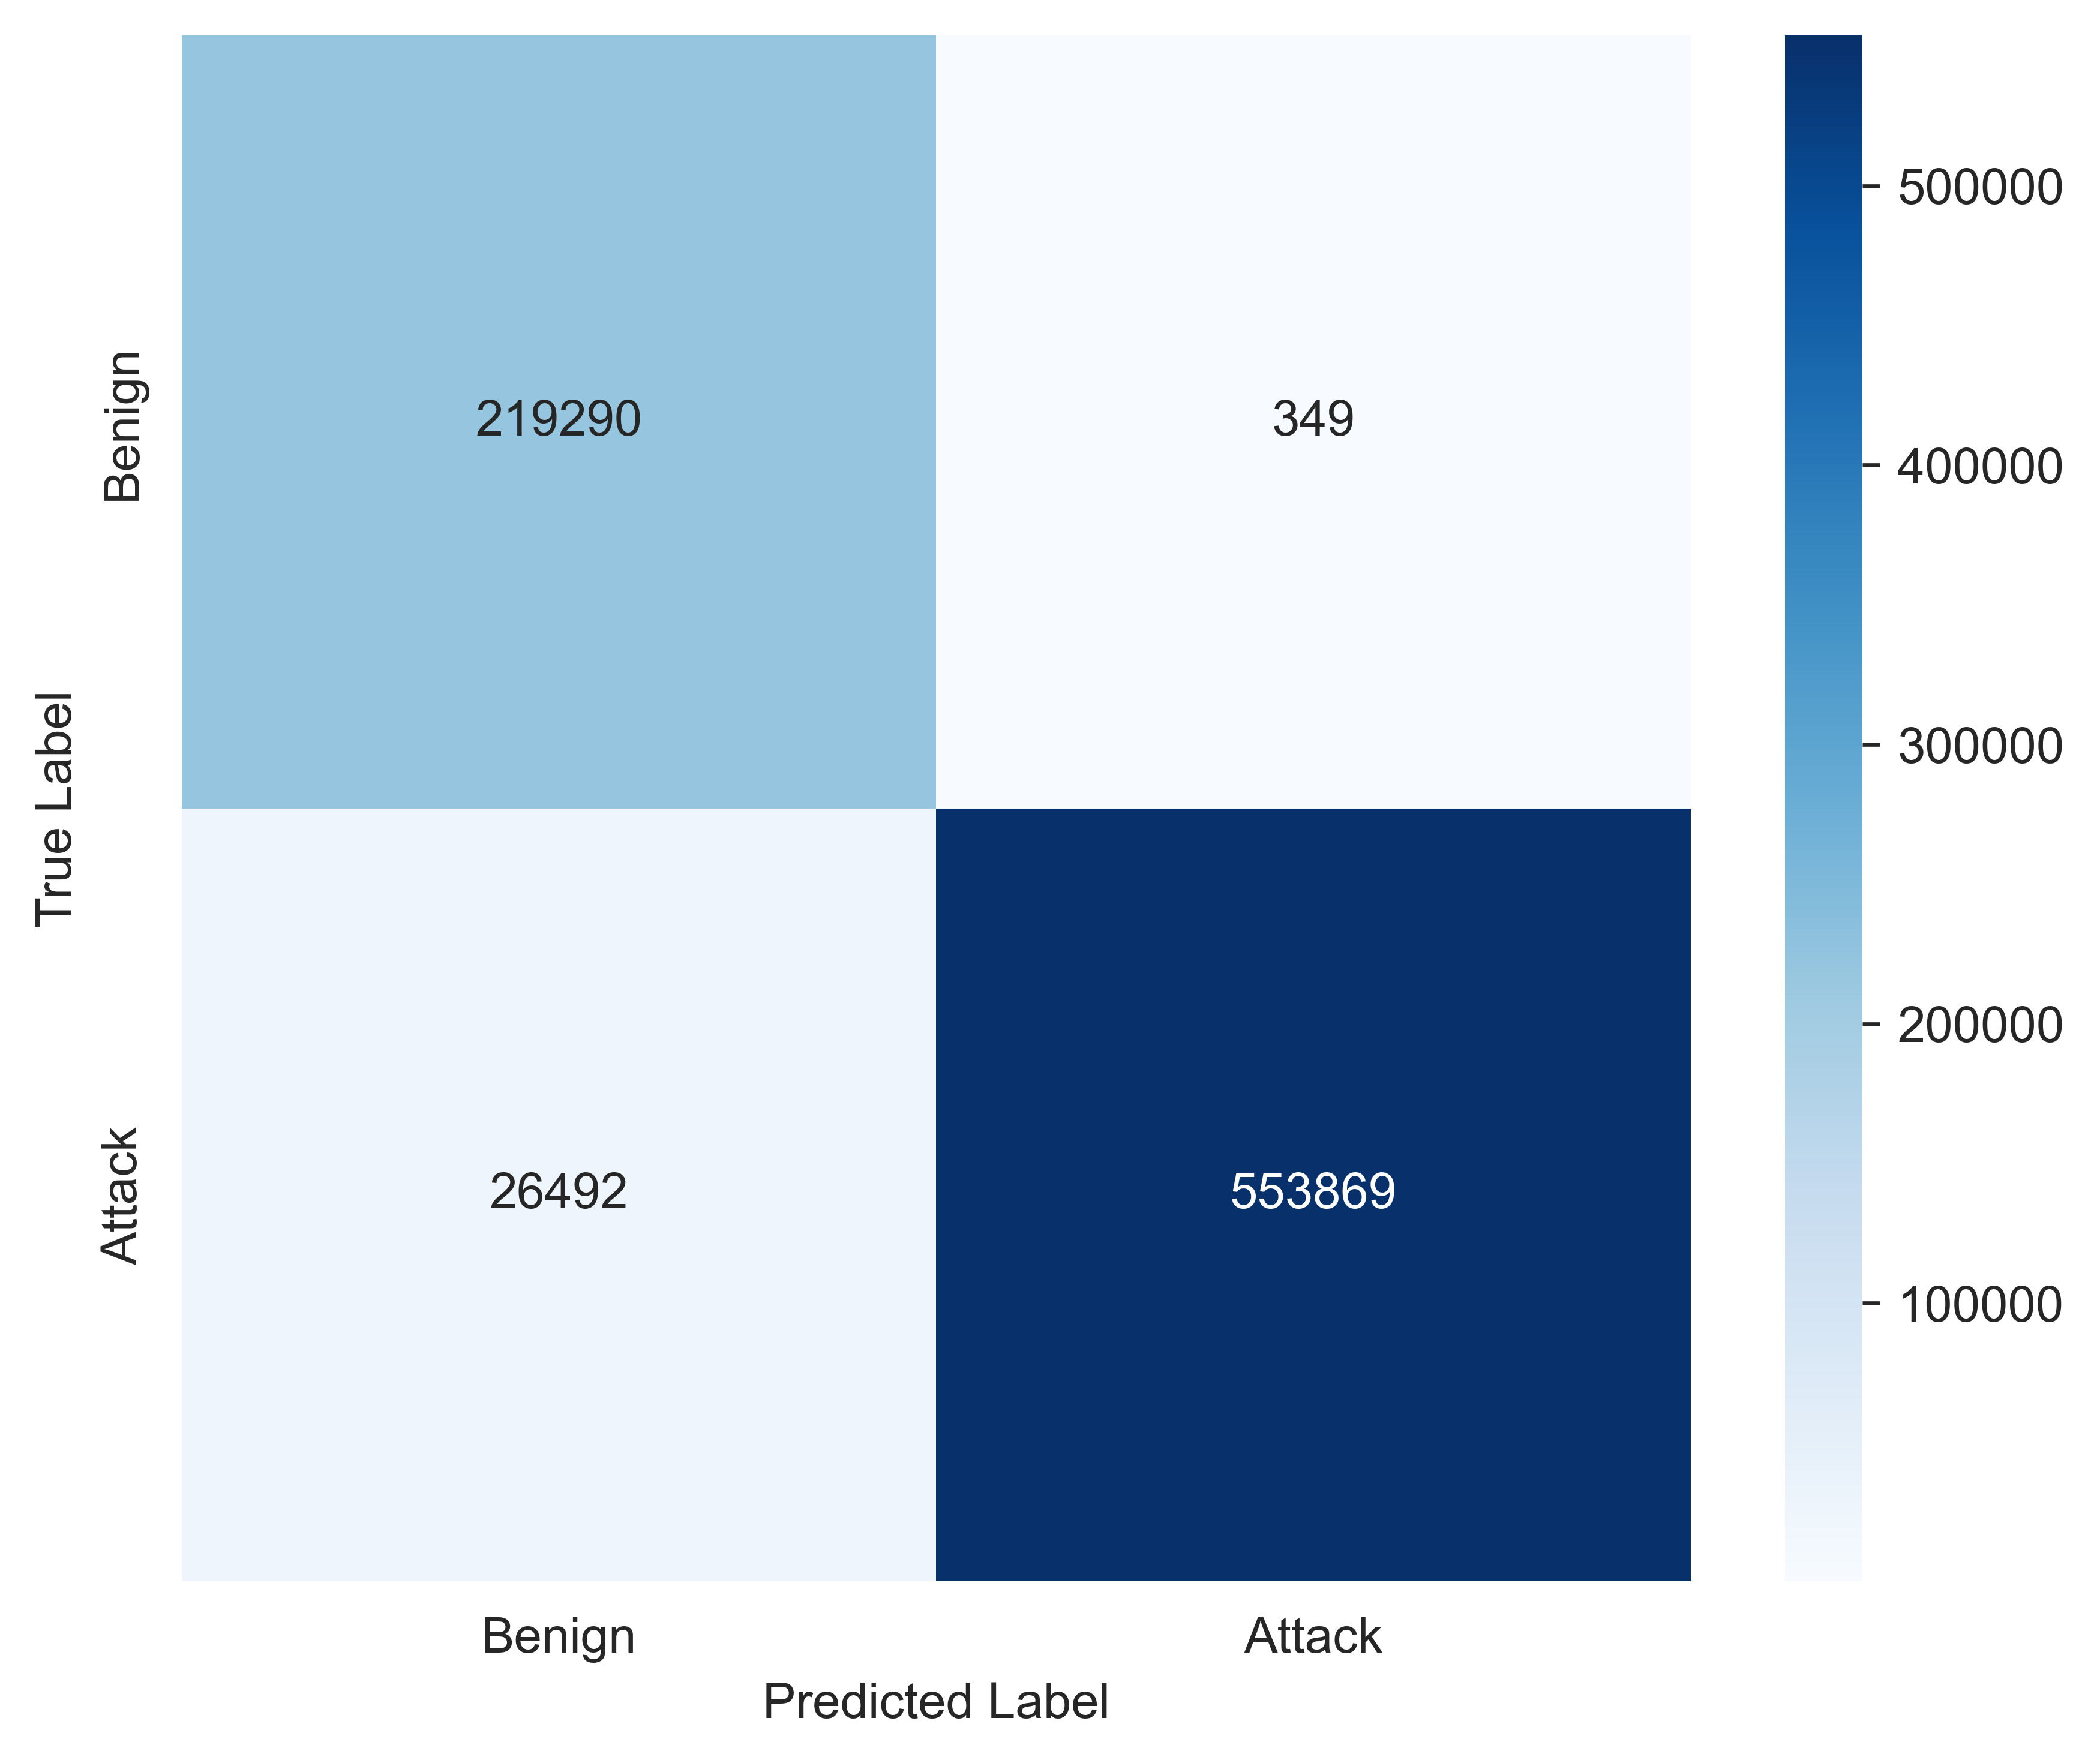

AdaBoost Accuracy: 98.12%
              precision    recall  f1-score   support

      Benign       0.95      0.99      0.97    219639
      Attack       0.99      0.98      0.99    580361

    accuracy                           0.98    800000
   macro avg       0.97      0.98      0.98    800000
weighted avg       0.98      0.98      0.98    800000



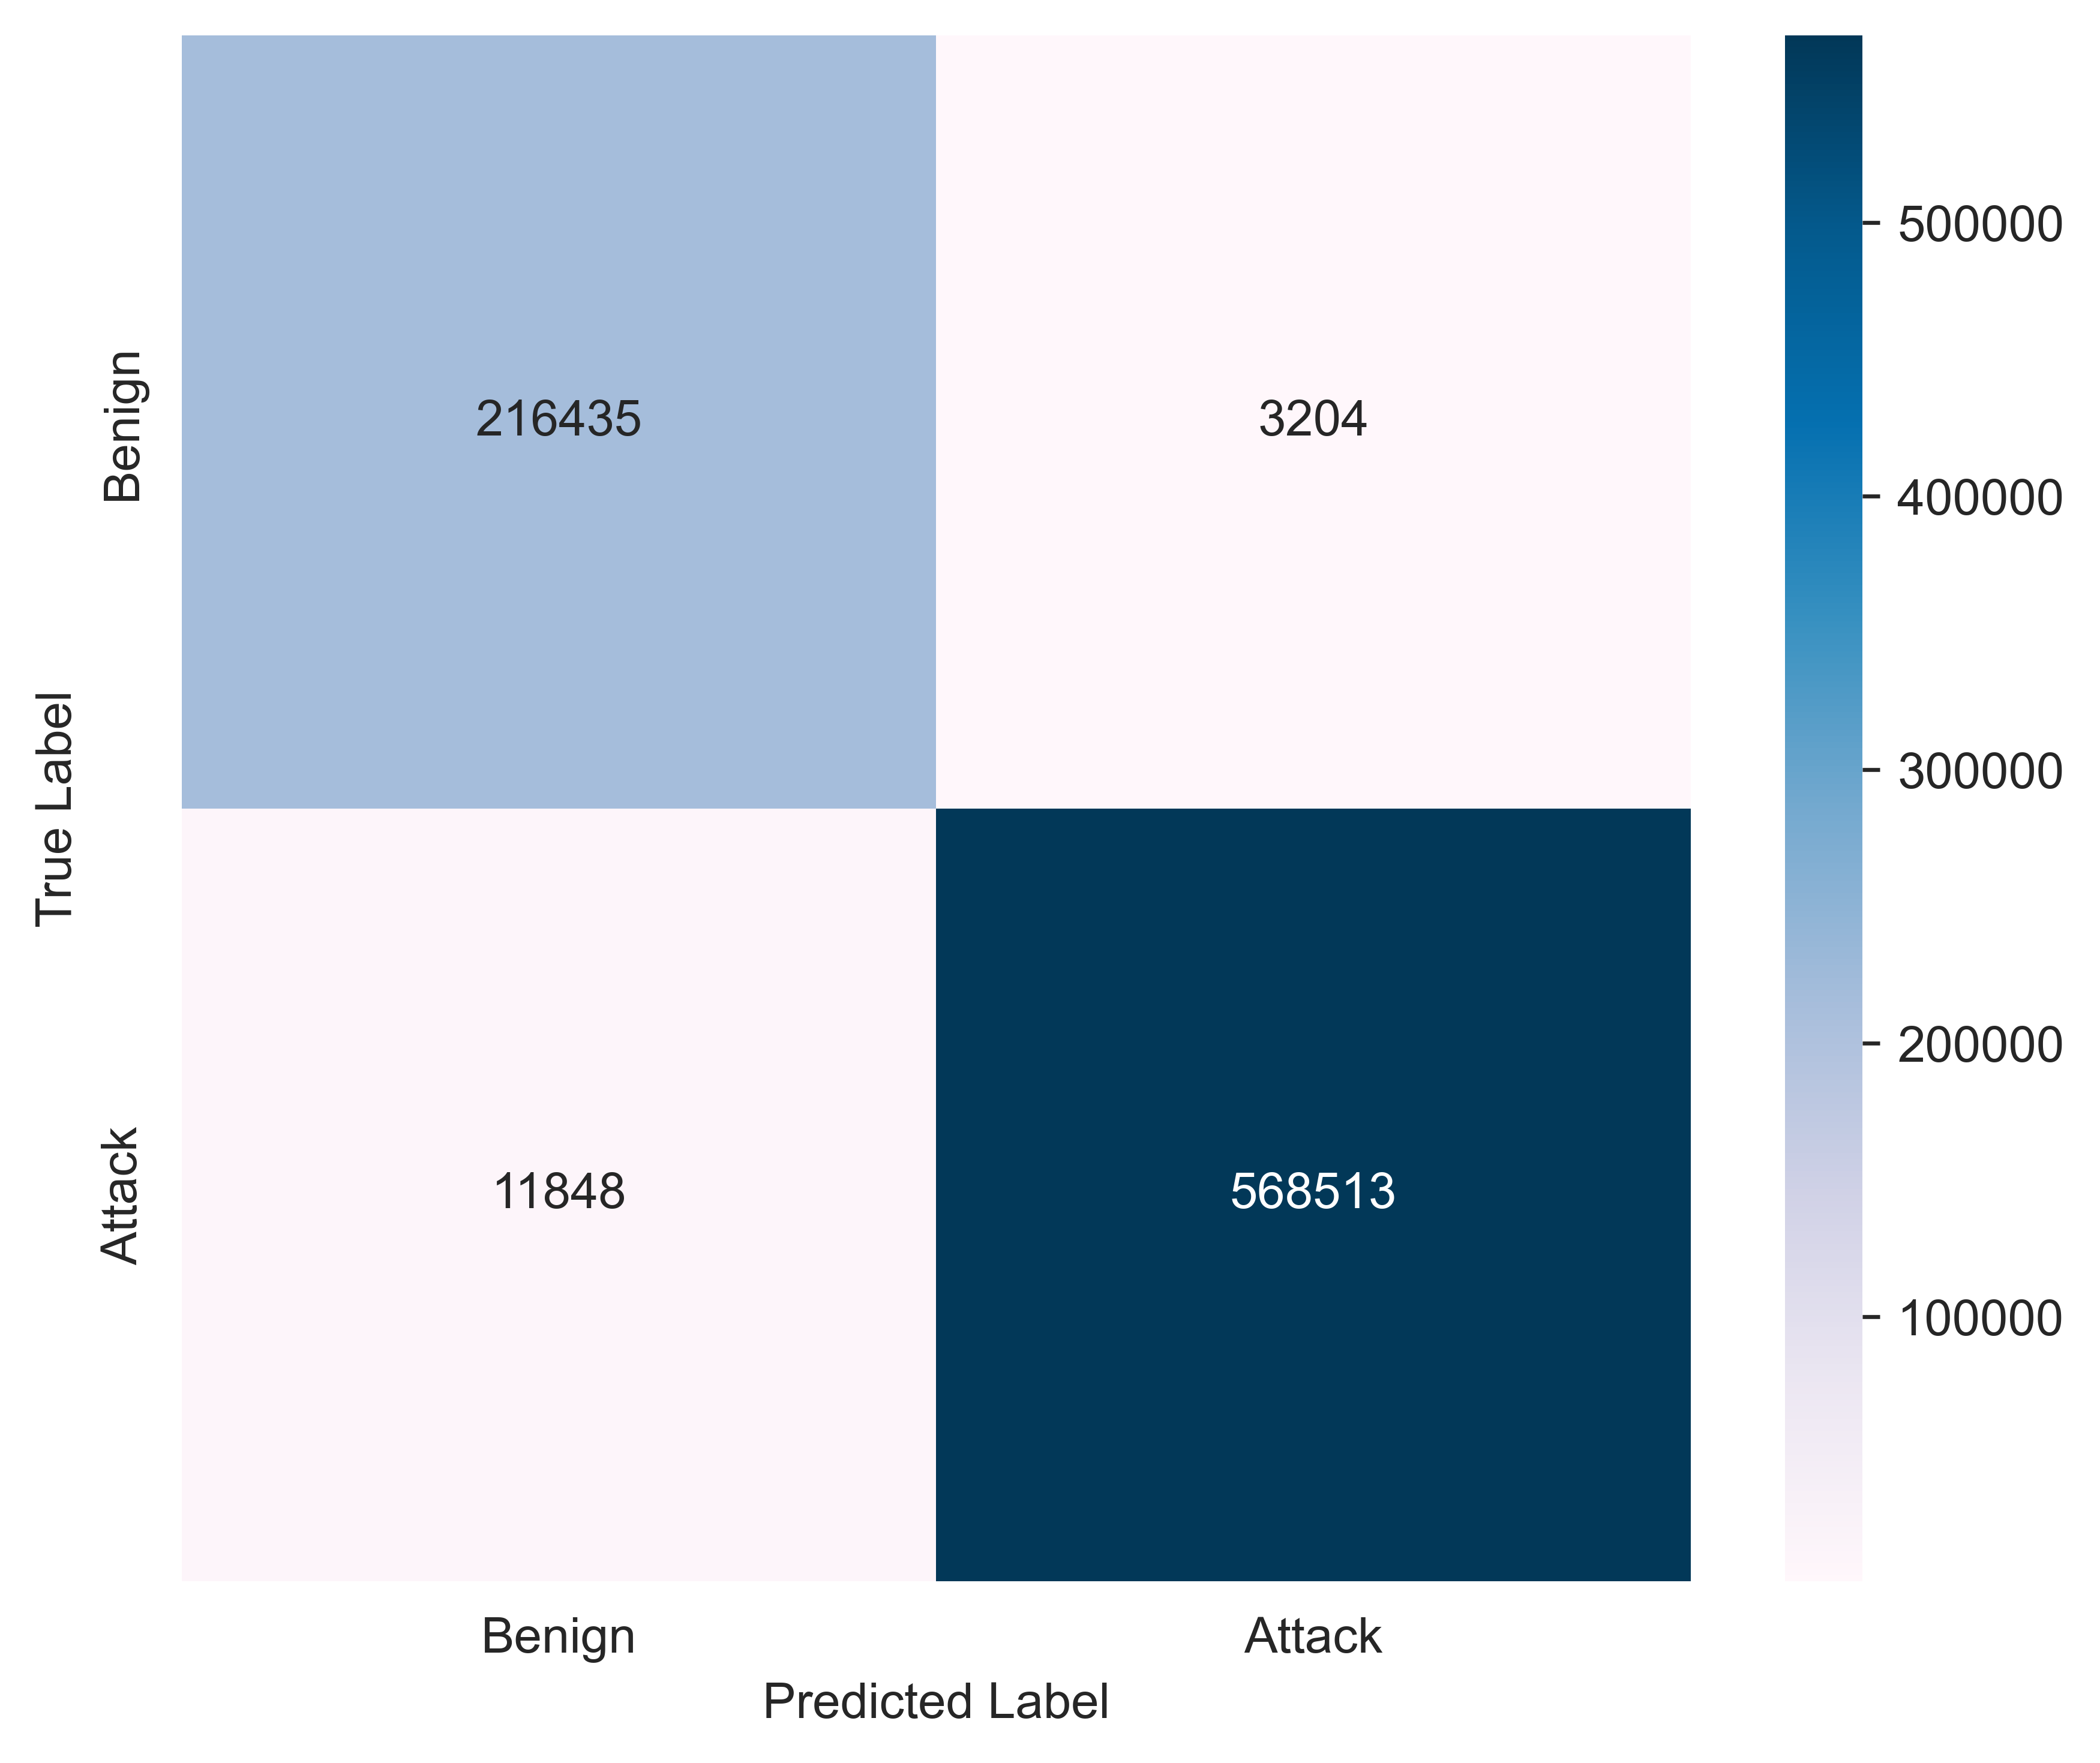

In [46]:


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression as LR2, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

KN_SAMPLE = 100_000
if X_train.shape[0] > KN_SAMPLE:
    knn_idx = np.random.choice(X_train.shape[0], KN_SAMPLE, replace=False)
    X_knn_train = X_train[knn_idx]
    y_knn_train = y_train[knn_idx]
else:
    X_knn_train, y_knn_train = X_train, y_train

baseline_models = [
    (DecisionTreeClassifier(max_depth=10, min_samples_leaf=50,
                            class_weight='balanced', random_state=RANDOM_STATE),
     "Decision Tree", "Greys"),
    (RandomForestClassifier(n_estimators=100, max_depth=14,
                            max_samples=0.1, class_weight='balanced',
                            n_jobs=-1, random_state=RANDOM_STATE),
     "Random Forest", "Reds"),
    (LR2(solver='saga', max_iter=500,
         class_weight='balanced',
         random_state=RANDOM_STATE),
     "Logistic Regression", "Oranges"),
    (SGDClassifier(loss='hinge', learning_rate='optimal',
                   max_iter=1000, tol=1e-3,
                   class_weight='balanced', random_state=RANDOM_STATE),
     "Linear SVM (SGD)", "Purples"),
    (KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
     "k-NN (subsampled)", "Greens"),
    (GaussianNB(), "Gaussian Naive Bayes", "Blues"),
    (AdaBoostClassifier(n_estimators=50, learning_rate=0.1,
                        random_state=RANDOM_STATE),
     "AdaBoost", "PuBu"),
]

for model, name, cmap in baseline_models:
    if name.startswith("k-NN"):
        model.fit(X_knn_train, y_knn_train)
    else:
        model.fit(X_train, y_train)
    evaluate_model(model, name, cmap=cmap)


In [47]:
# ### 6.12) Inference Time Benchmarking

from time import perf_counter


def measure_latency(model, X):
    """return total_ms, avg_ms"""
    _ = model.predict(X[:1])  # warm-up
    start = perf_counter()
    _ = model.predict(X)
    end = perf_counter()
    total_ms = (end - start) * 1e3
    avg_ms = total_ms / X.shape[0]
    return total_ms, avg_ms


all_models = [
    (clf_xgb, "XGBoost"),
    (clf_lgb, "LightGBM"),
    (clf_cat, "CatBoost"),
    (clf_ngb, "NGBoost"),
]
all_models += [(mdl, name) for mdl, name, _ in models]
all_models += [(mdl, name) for mdl, name, _ in baseline_models]

for model, name in all_models:
    total_ms, avg_ms = measure_latency(model, X_test)
    print(f"{name:20s} → Total: {total_ms:8.1f} ms | Per sample: {avg_ms:6.4f} ms")

XGBoost              → Total:    676.4 ms | Per sample: 0.0008 ms


C:\Users\ss160\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\ss160\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM             → Total:    548.0 ms | Per sample: 0.0007 ms
CatBoost             → Total:   4303.0 ms | Per sample: 0.0054 ms
NGBoost              → Total:  15516.7 ms | Per sample: 0.0194 ms
ExtraTrees           → Total:   1550.2 ms | Per sample: 0.0019 ms
LogisticRegression   → Total:     22.7 ms | Per sample: 0.0000 ms
Decision Tree        → Total:     63.5 ms | Per sample: 0.0001 ms
Random Forest        → Total:    556.3 ms | Per sample: 0.0007 ms
Logistic Regression  → Total:     33.4 ms | Per sample: 0.0000 ms
Linear SVM (SGD)     → Total:     28.8 ms | Per sample: 0.0000 ms
k-NN (subsampled)    → Total:  41937.0 ms | Per sample: 0.0524 ms
Gaussian Naive Bayes → Total:    243.3 ms | Per sample: 0.0003 ms
AdaBoost             → Total:   3604.5 ms | Per sample: 0.0045 ms
